# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as ss
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
sns.set_theme()

np.random.seed(42)

# Download do Database

In [2]:
#Download do arquivo CSV
!wget --quiet -P /tmp/ https://raw.githubusercontent.com/EduardoFernandes1410/ICD/main/Dataset/steam.csv
!wget --quiet -P /tmp/ https://raw.githubusercontent.com/EduardoFernandes1410/ICD/main/Dataset/steamspy_tag_data.csv

In [3]:
df = pd.read_csv('/tmp/steam.csv')
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


#### Tranforma o average_playtime e median_playtime de minutos para horas


In [4]:
df["average_playtime"] /= 60
df["median_playtime"] /= 60

#### Exemplo de análise exploratória: comparação entre avaliações positivas e negativas por publisher.

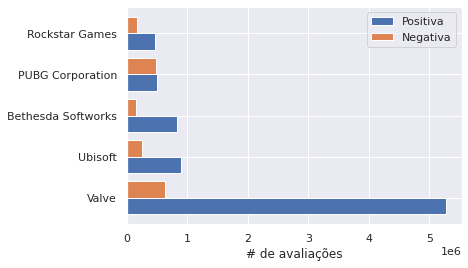

In [5]:
neg_rate = df.groupby(['publisher'])['negative_ratings'].sum()
pos_rate = df.groupby(['publisher'])['positive_ratings'].sum().sort_values(ascending=False)
sample = pos_rate.iloc[:5]

vals = np.arange(len(sample.index))

# fig = plt.figure()
# plt.xticks(vals, sample.index, rotation='vertical')
# bar1 = plt.bar(vals-0.2, sample.values, width=0.4)
# bar2 = plt.bar(vals+0.2, neg_rate[sample.index].values, width=0.4)
# plt.ylabel("# de avaliações")
# plt.legend((bar1, bar2), ('Positivo', 'Negativo'))

fig = plt.figure()
plt.yticks(vals, sample.index, rotation='horizontal')
bar1 = plt.barh(vals-0.2, sample.values, 0.4)
bar2 = plt.barh(vals+0.2, neg_rate[sample.index].values, 0.4)
plt.xlabel("# de avaliações")
plt.legend((bar1, bar2), ('Positiva', 'Negativa'))

plt.show()

#1) Quais os gêneros dos jogos mais vendidos na plataforma?

## Gêneros agrupados

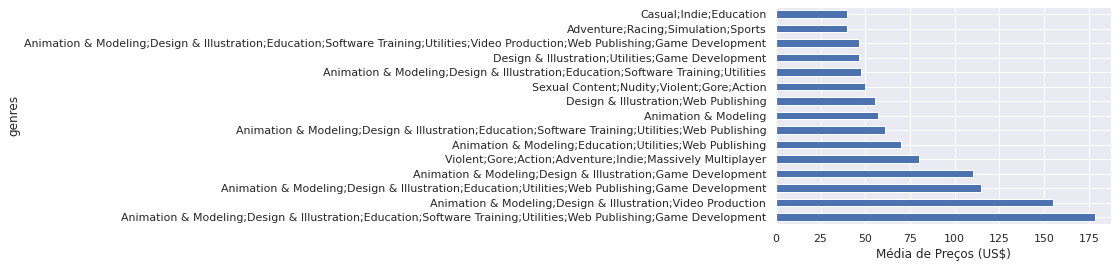

In [6]:
df.groupby("genres").mean()["price"].sort_values(ascending=False).iloc[:15].plot.barh()
plt.xlabel("Média de Preços (US$)");

##Gêneros separados

In [7]:
count = dict()
for _,e in df[["genres", "owners"]].iterrows():
    for d in e.genres.split(';'):
        if not d in count.keys():
            count[d] = 0
        count[d] += np.mean([int(x) for x in e.owners.split('-')])

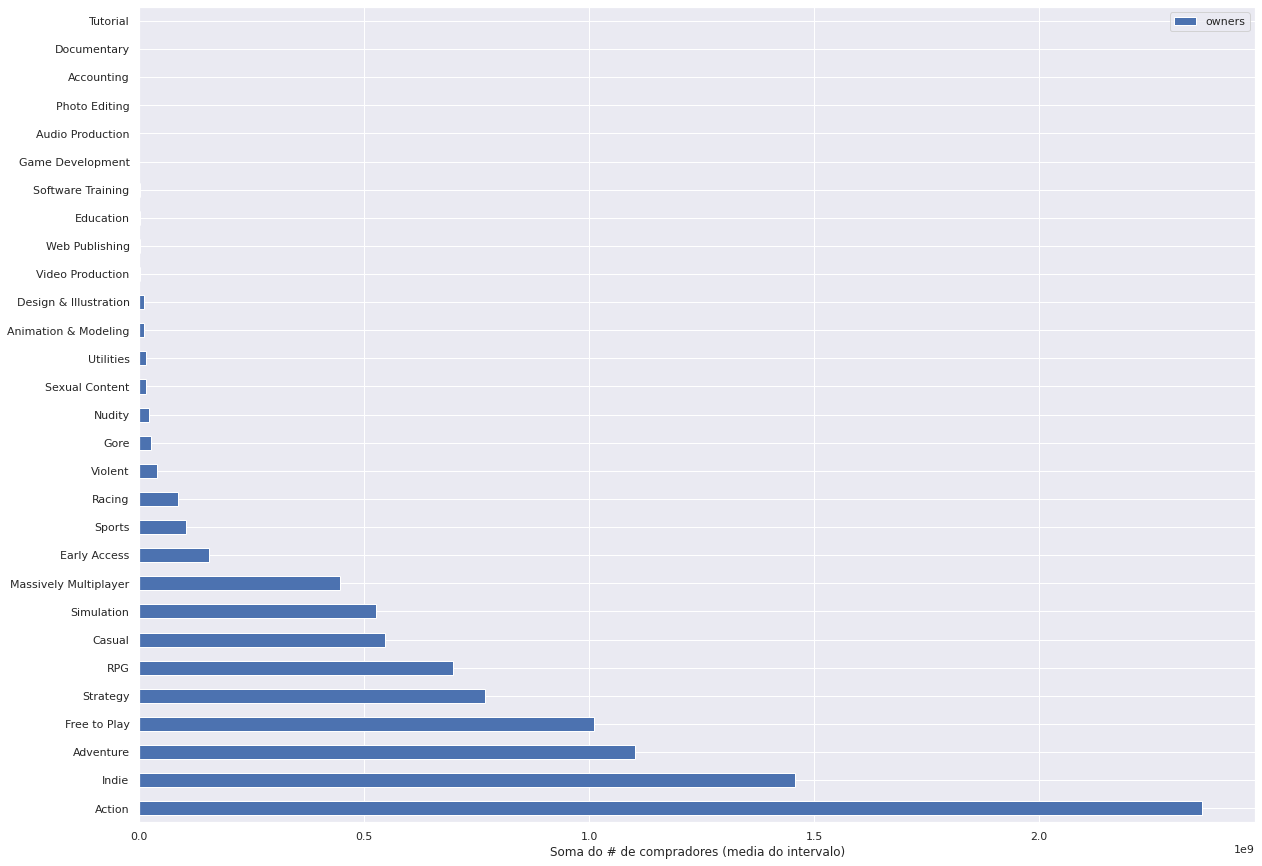

In [8]:
fig, ax = plt.subplots(figsize=(20, 15))
df0 = pd.DataFrame.from_dict(count, orient='index', columns=['owners'])
df0.sort_values(by='owners', ascending=False).plot.barh(ax = ax)
plt.xlabel("Soma do # de compradores (media do intervalo)");

#2) Quais gêneros estão relacionados com mais tempo de jogo?

In [9]:
count = dict()
acumulator = dict()
for _,e in df[["genres", "average_playtime"]].iterrows():
    for d in e.genres.split(';'):
        if not d in count.keys():
            acumulator[d] = 0
            count[d] = 0
        count[d] += 1
        acumulator[d] += e.average_playtime
    
for k, v in count.items():
    acumulator[k] = acumulator[k]/count[k]

Text(0.5, 0, 'Mean Average Playtime (Horas)')

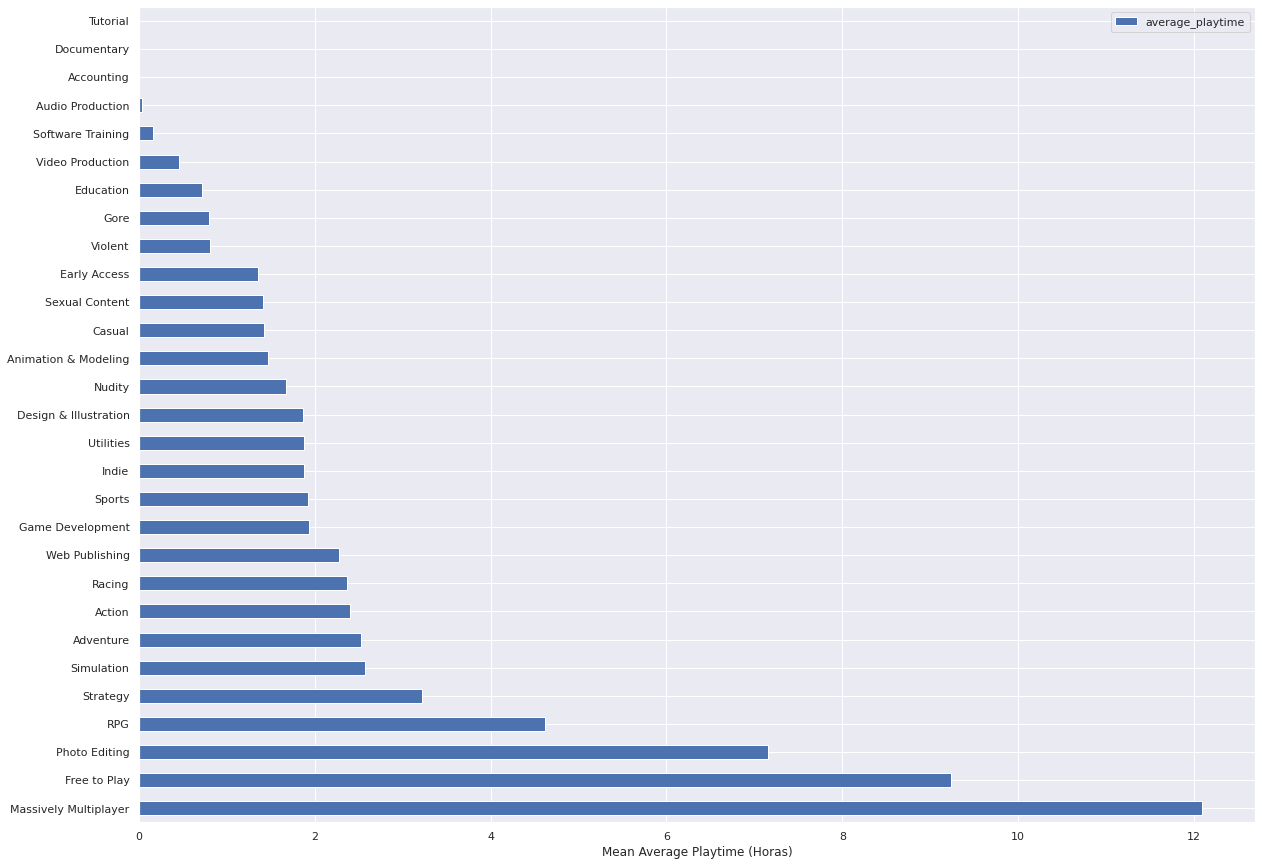

In [10]:
fig, ax = plt.subplots(figsize=(20, 15))
df0 = pd.DataFrame.from_dict(acumulator, orient='index', columns=['average_playtime'])
ax = df0.sort_values(by='average_playtime', ascending=False).plot.barh(ax=ax)
plt.xlabel("Mean Average Playtime (Horas)")

In [11]:
count_box = dict()
acumulator_box = dict()
for _,e in df[["genres", "average_playtime"]].iterrows():
    for d in e.genres.split(';'):
        if not d in count_box.keys():
            acumulator_box[d] = []
            count_box[d] = 0
        count_box[d] += 1
        acumulator_box[d] += [e.average_playtime]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


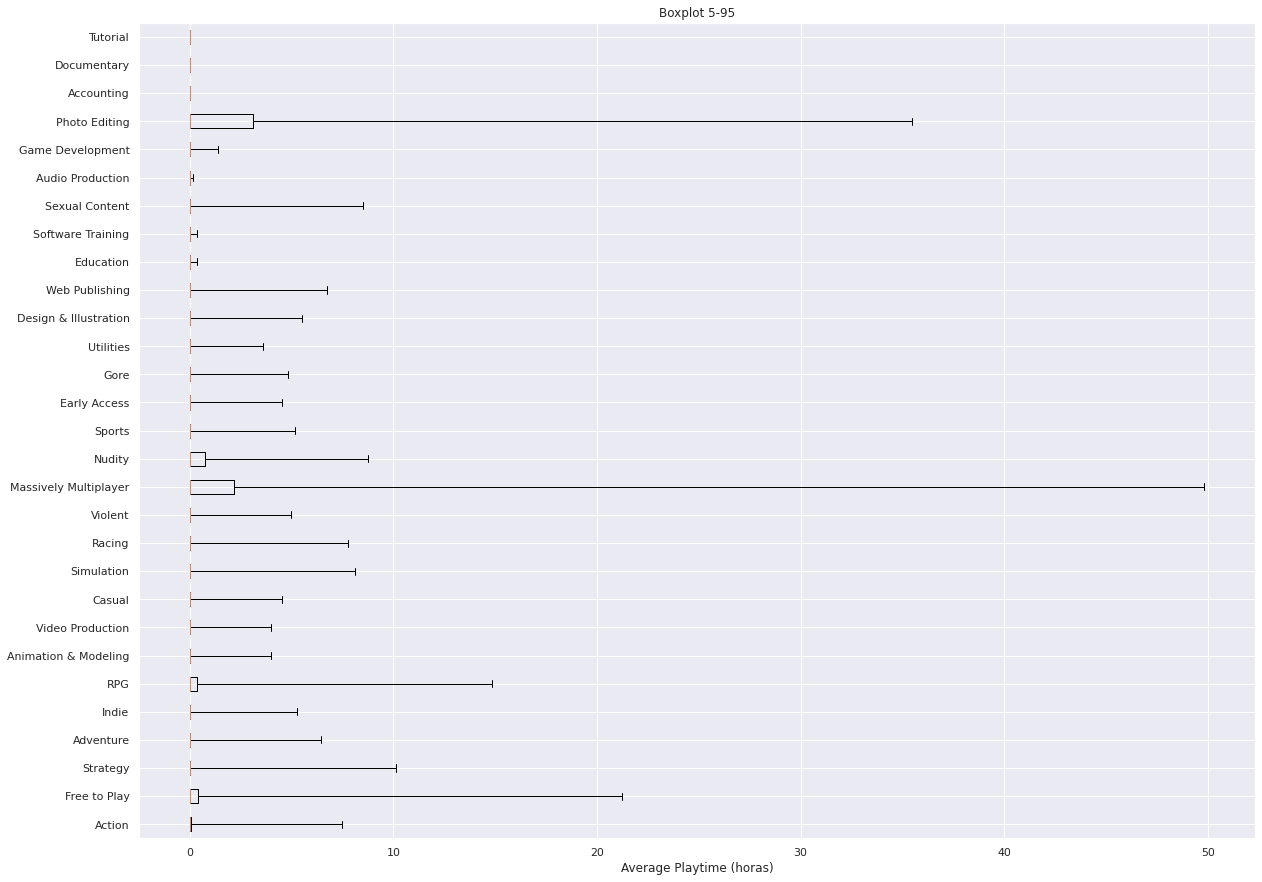

In [12]:
fig, ax = plt.subplots(figsize=(20,15))
ax.boxplot(acumulator_box.values(), vert=False, whis=[5, 95], showfliers=False);
ax.set_yticklabels(acumulator_box.keys());
plt.xlabel("Average Playtime (horas)");
plt.title("Boxplot 5-95");

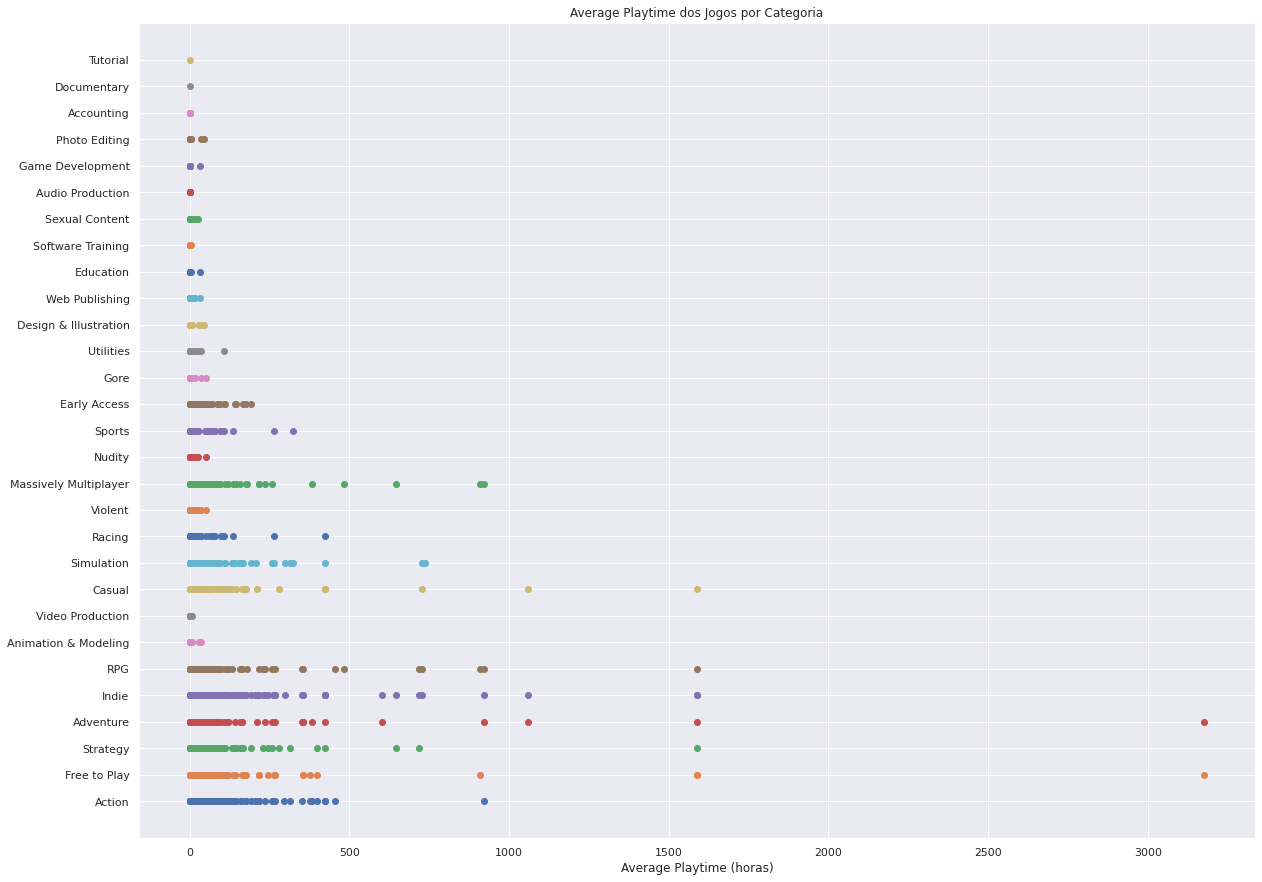

In [13]:
fig, ax = plt.subplots(figsize=(20,15))
for k, v in acumulator_box.items():
  ax.scatter(list(v), [str(k) for i in range(len(v))]);
plt.xlabel("Average Playtime (horas)")
plt.title("Average Playtime dos Jogos por Categoria");

#3) Como o preço dos jogos se relaciona com o tempo de jogo e quantidade vendida?

## Correlação entre o preço e o tempo de jogo médio.

Correlação: 0.3467230535414478


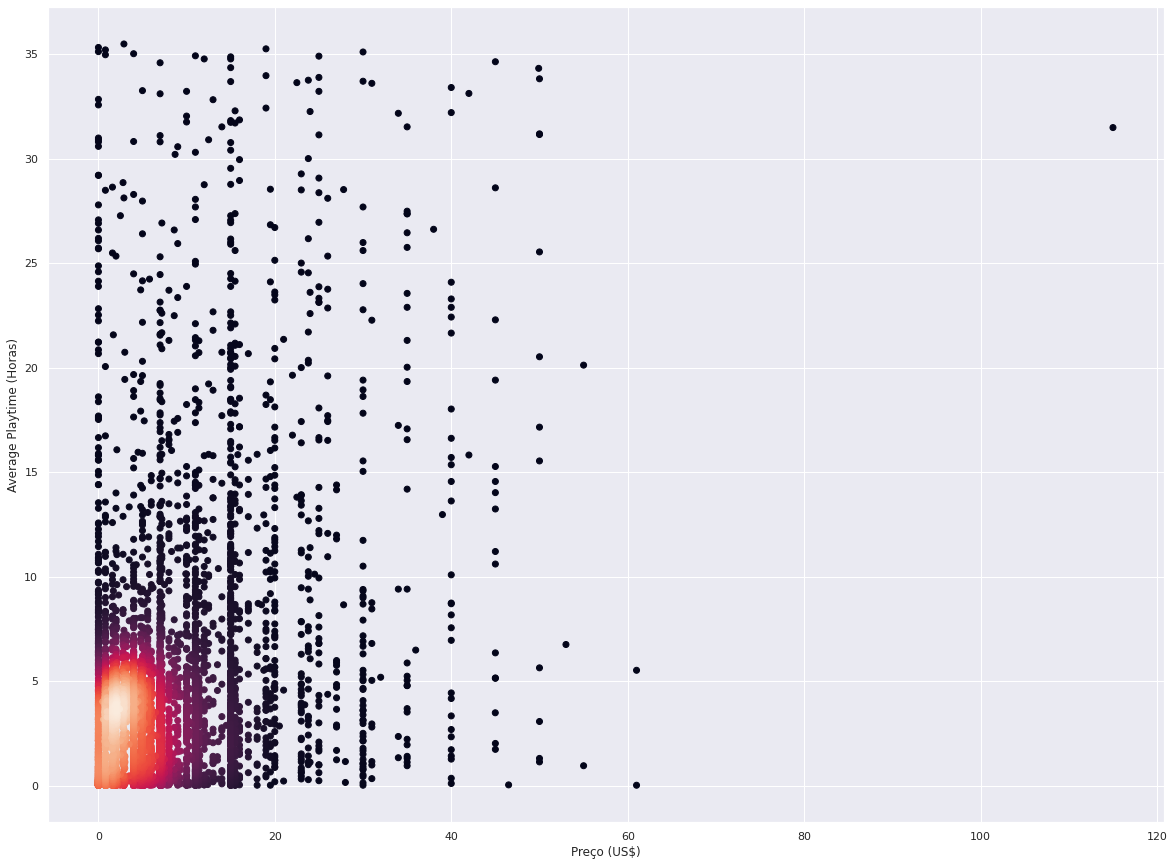

In [14]:
subdf = df[['name', 'price', 'average_playtime']]

i_max = np.percentile(subdf.average_playtime.values, 99)
i_min = np.percentile(subdf.average_playtime.values, 1)
subdf = subdf[subdf.average_playtime > i_min]
subdf = subdf[subdf.average_playtime < i_max]

x = np.asarray(subdf.values[:, 1:], dtype=np.float32)
y = np.corrcoef([x[:,0], x[:, 1]])
print("Correlação: " + str(y[0, 1]))

fig, ax = plt.subplots(figsize=(20, 15))
a = x[:,0]
b = x[:,1]

ab = np.vstack([a,b])
z = gaussian_kde(ab)(ab)

idx = z.argsort()
a, b, z = a[idx], b[idx], z[idx]

plt.scatter(a, b, c=z)

plt.xlabel('Preço (US$)');
plt.ylabel('Average Playtime (Horas)');

## Correlação entre o preço e o número de vendas.

Correlação de Pearson: 0.11676896129313256
Correlação de Spearman: 0.0676948558411098


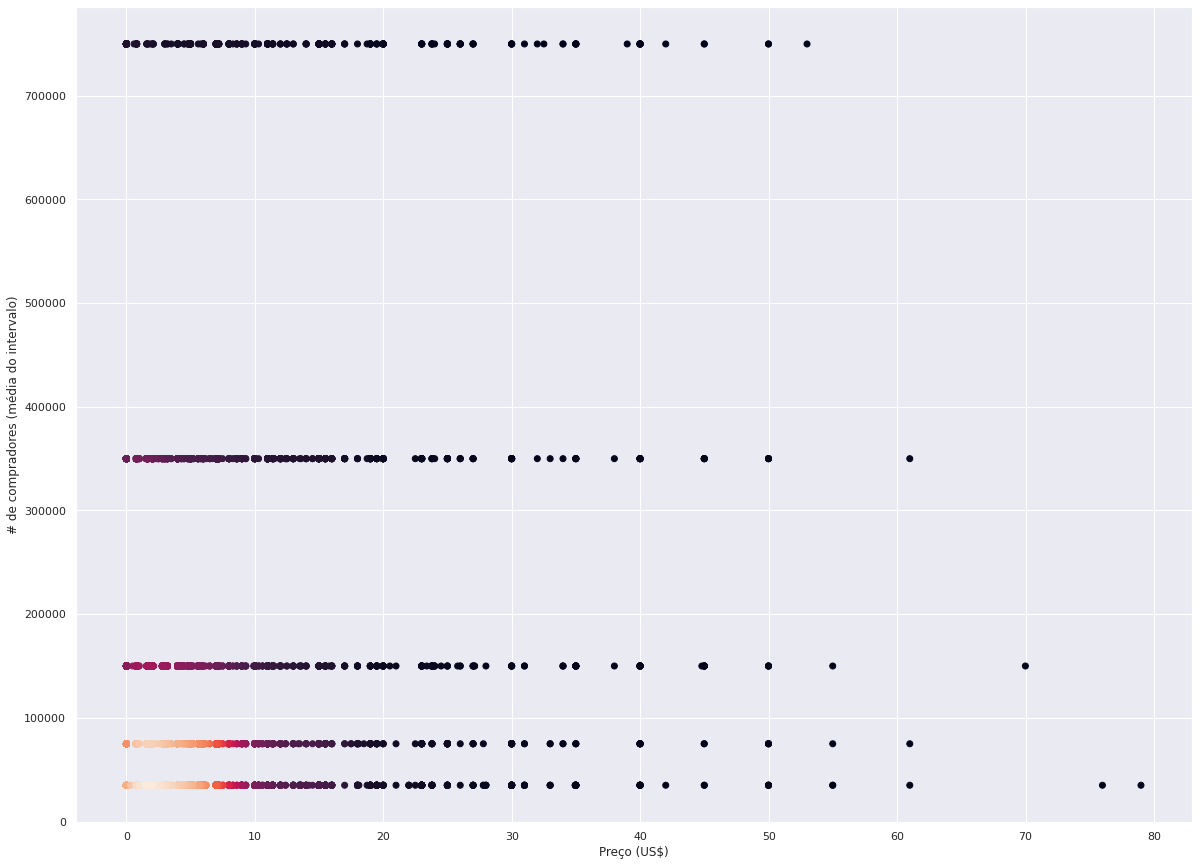

In [15]:
subdf = df[['name', 'price', 'owners']].iloc[:, 1:]

subdf['owners'] = [np.mean([int(x) for x in e.split('-') ]) for e in subdf.owners]
subdf.sort_values(by='owners', ascending=False, inplace=True)

i_max = np.percentile(subdf.owners.values, 99)
i_min = np.percentile(subdf.owners.values, 1)
subdf = subdf[subdf.owners > i_min]
subdf = subdf[subdf.owners < i_max]

x = subdf.values[:, [0,1]]

y = np.corrcoef([x[:,0], x[:,1]])
print("Correlação de Pearson: " + str(y[0,1]))

y = ss.spearmanr(x[:,0], x[:,1])
print("Correlação de Spearman: " + str(y[0]))

fig, ax = plt.subplots(figsize=(20, 15))
idx = np.argsort(x[:,1])[::-1]
a = x[:,0]
b = x[:,1]

ab = np.vstack([a,b])
z = gaussian_kde(ab)(ab)

idx = z.argsort()
a, b, z = a[idx], b[idx], z[idx]

plt.scatter(a, b, c=z)

plt.xlabel('Preço (US$)')
plt.ylabel('# de compradores (média do intervalo)');

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Correlação (media do intervalo de preço e mediana do número de jogadores): 0.026620571722719064


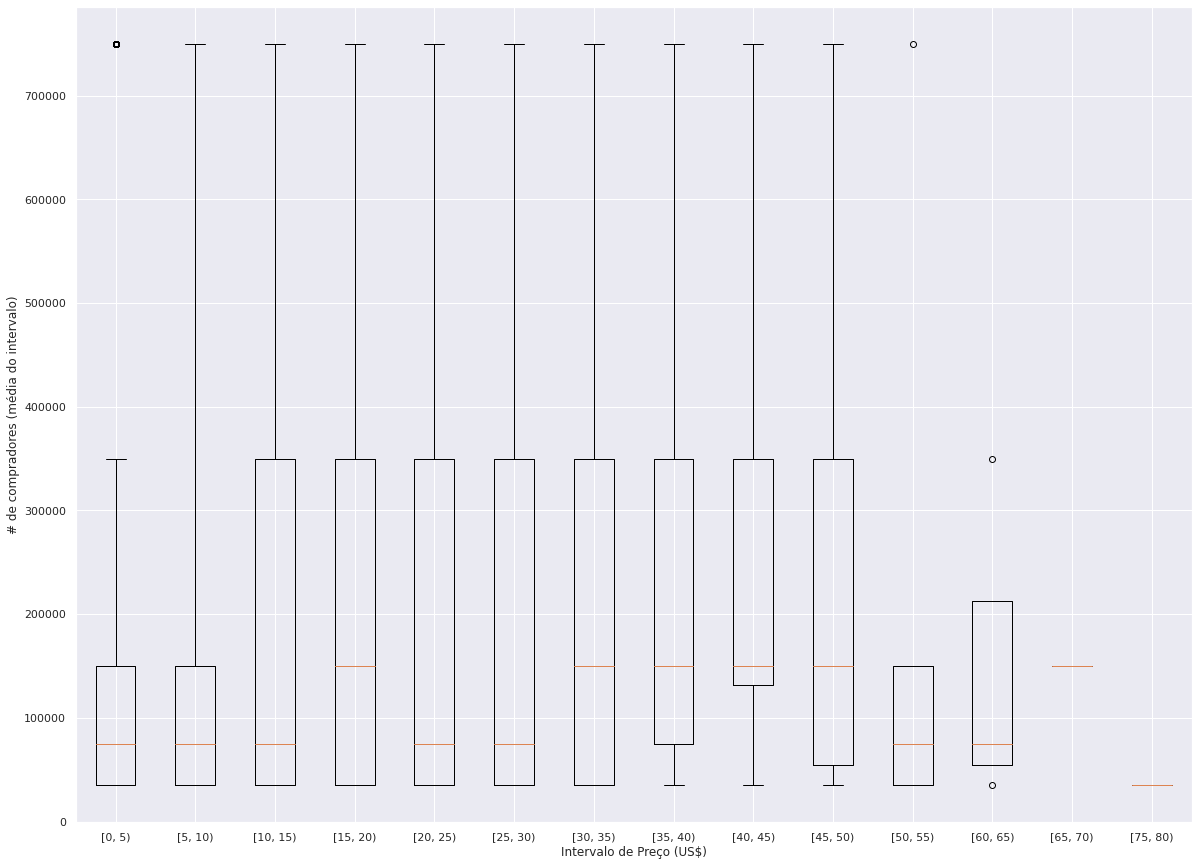

In [16]:
sub_df = pd.DataFrame(x, columns=['Price', 'Owners'])
groups = sub_df.groupby(pd.cut(sub_df['Price'], np.arange(0, 85, 5), right=False))

fig, ax = plt.subplots(figsize=(20,15))
data = dict()
for i in range(0, 80, 5):
  l, r = i, i+5
  if(len(groups.groups[pd.Interval(l, r, closed="left")]) > 0):
    data["[" + str(l) + ", " + str(r) + ")"] = groups.get_group(pd.Interval(l,r, closed="left"))["Owners"].values;

ax.boxplot(data.values(), whis=[5, 95], showfliers=True);
ax.set_xticklabels(data.keys());
plt.xlabel("Intervalo de Preço (US$)")
plt.ylabel("# de compradores (média do intervalo)");

# Correlacao entre media do intervalo de preco e mediana do numero de jogadores
x_corr = []
y_corr = []
for i in range(0, 80, 5):
  l, r = i, i+5
  k = "[" + str(l) + ", " + str(r) + ")"
  if k in data.keys():
    x_corr += [(l + r) / 2]
    y_corr += [np.median(data[k])]

print("Correlação (media do intervalo de preço e mediana do número de jogadores): " + str(np.corrcoef(x_corr, y_corr)[0,1]))

#4) O número de conquistas de um jogo está relacionado com o tempo médio de jogo deste?

## Correlação entre o número de conquistas possíveis em um jogo e o tempo de jogo médio.

Correlação: 0.12496782220199862


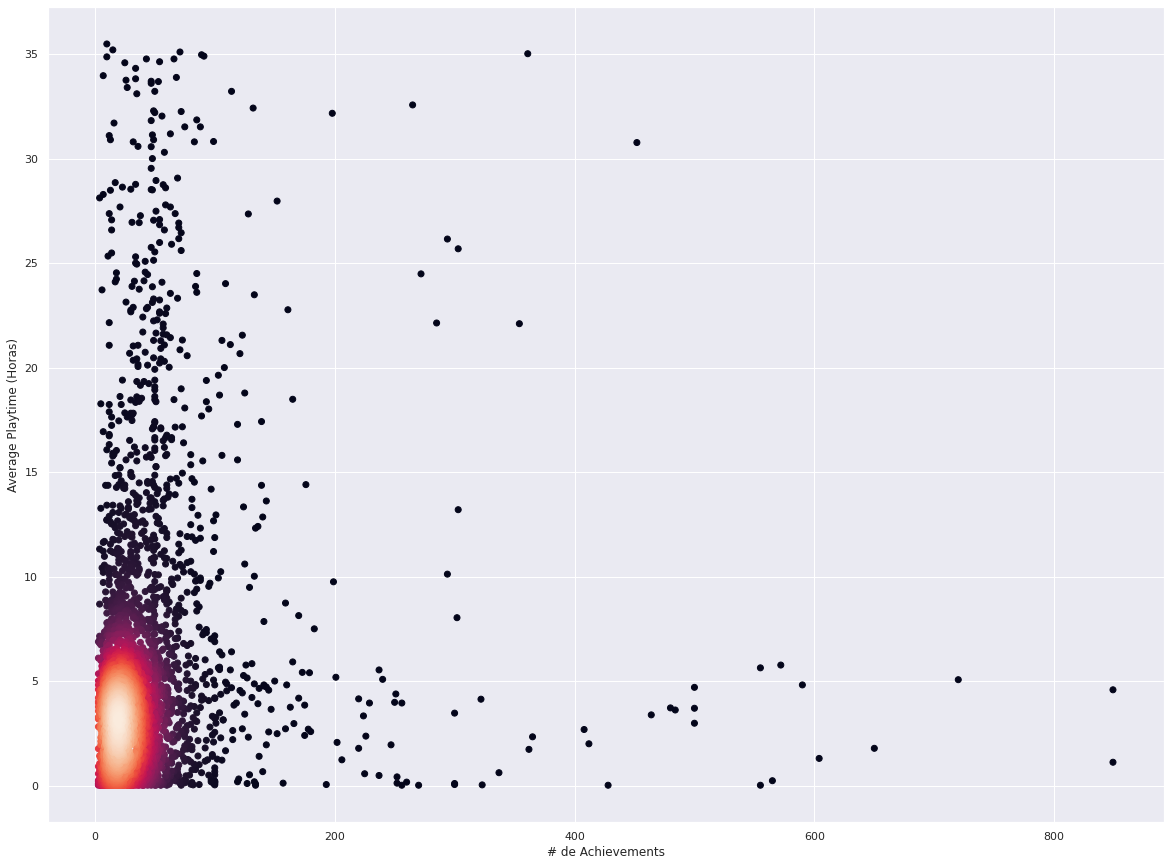

In [17]:
subdf = df[['name', 'achievements', 'average_playtime']].iloc[:, 1:]

i_max = np.percentile(subdf.average_playtime.values, 99)
i_min = np.percentile(subdf.average_playtime.values, 1)
subdf = subdf[subdf.average_playtime > i_min]
subdf = subdf[subdf.average_playtime < i_max]

subdf = subdf[subdf.achievements > 0]
subdf = subdf[subdf.average_playtime > 0]
subdf.sort_values(by='average_playtime', ascending=False, inplace=True)

i_max = np.percentile(subdf.achievements.values, 99)
i_min = np.percentile(subdf.achievements.values, 1)
subdf = subdf[subdf.achievements > i_min]
subdf = subdf[subdf.achievements < i_max]

x = subdf.values[:, [0,1]]
y = np.corrcoef([x[:,0], x[:,1]])
print("Correlação: " + str(y[0,1]))

fig, ax = plt.subplots(figsize=(20, 15))
a = x[:,0]
b = x[:,1]

ab = np.vstack([a,b])
z = gaussian_kde(ab)(ab)

idx = z.argsort()
a, b, z = a[idx], b[idx], z[idx]

plt.scatter(a, b, c=z)

plt.xlabel('# de Achievements')
plt.ylabel('Average Playtime (Horas)');

# Explorando o dataset

## Correlação entre o \# de avaliações positivas e o tempo de jogo médio.


Correlação: 0.3401765253125109


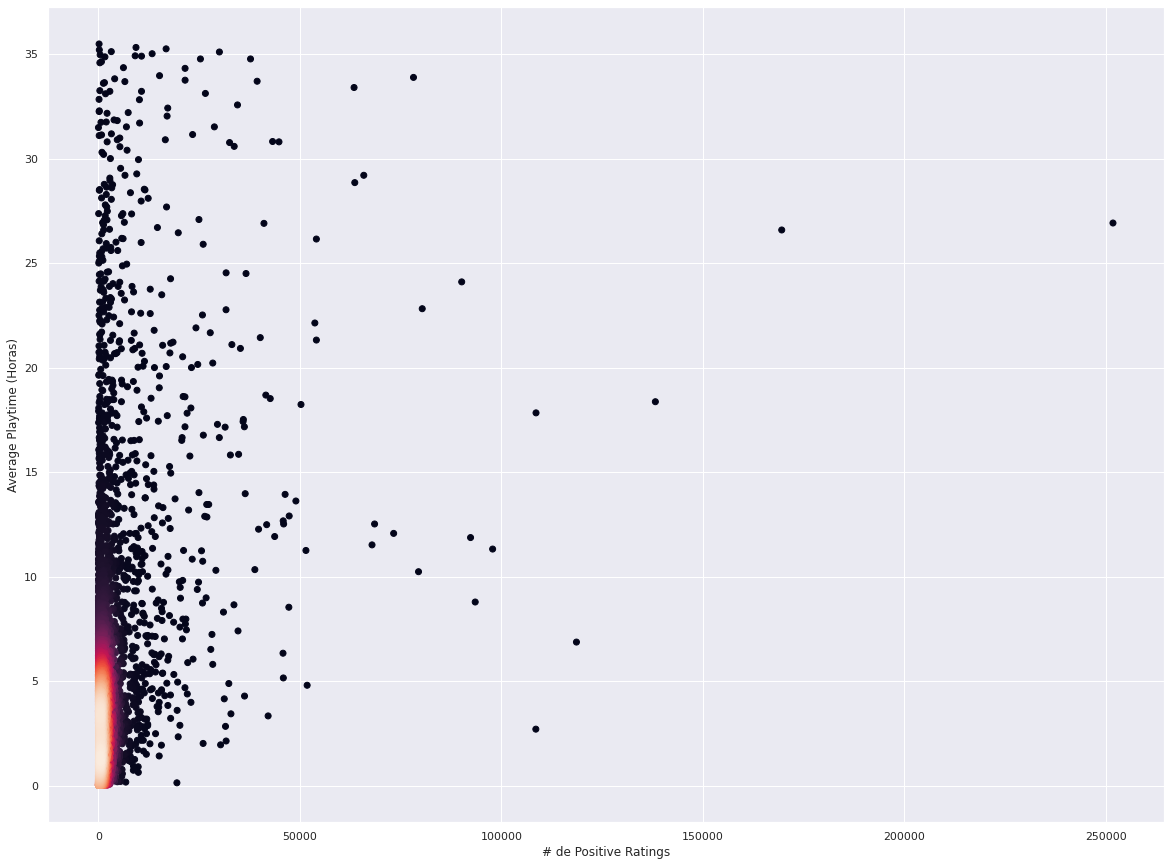

In [18]:
subdf = df[['name', 'positive_ratings', 'average_playtime']]

i_max = np.percentile(subdf.average_playtime.values, 99)
i_min = np.percentile(subdf.average_playtime.values, 1)
subdf = subdf[subdf.average_playtime > i_min]
subdf = subdf[subdf.average_playtime < i_max]

x = np.asarray(subdf.values[:, 1:], dtype=np.float32)
y = np.corrcoef([x[:,0], x[:,1]])
print("Correlação: " + str(y[0,1]))

fig, ax = plt.subplots(figsize=(20, 15))
a = x[:,0]
b = x[:,1]

ab = np.vstack([a,b])
z = gaussian_kde(ab)(ab)

idx = z.argsort()
a, b, z = a[idx], b[idx], z[idx]

plt.scatter(a, b, c=z)

plt.xlabel('# de Positive Ratings')
plt.ylabel('Average Playtime (Horas)');

## Correlação entre a razão do \# de avaliações positivas sobre o \# de avaliações e o tempo de jogo médio.

Correlação: 0.13052745043001393


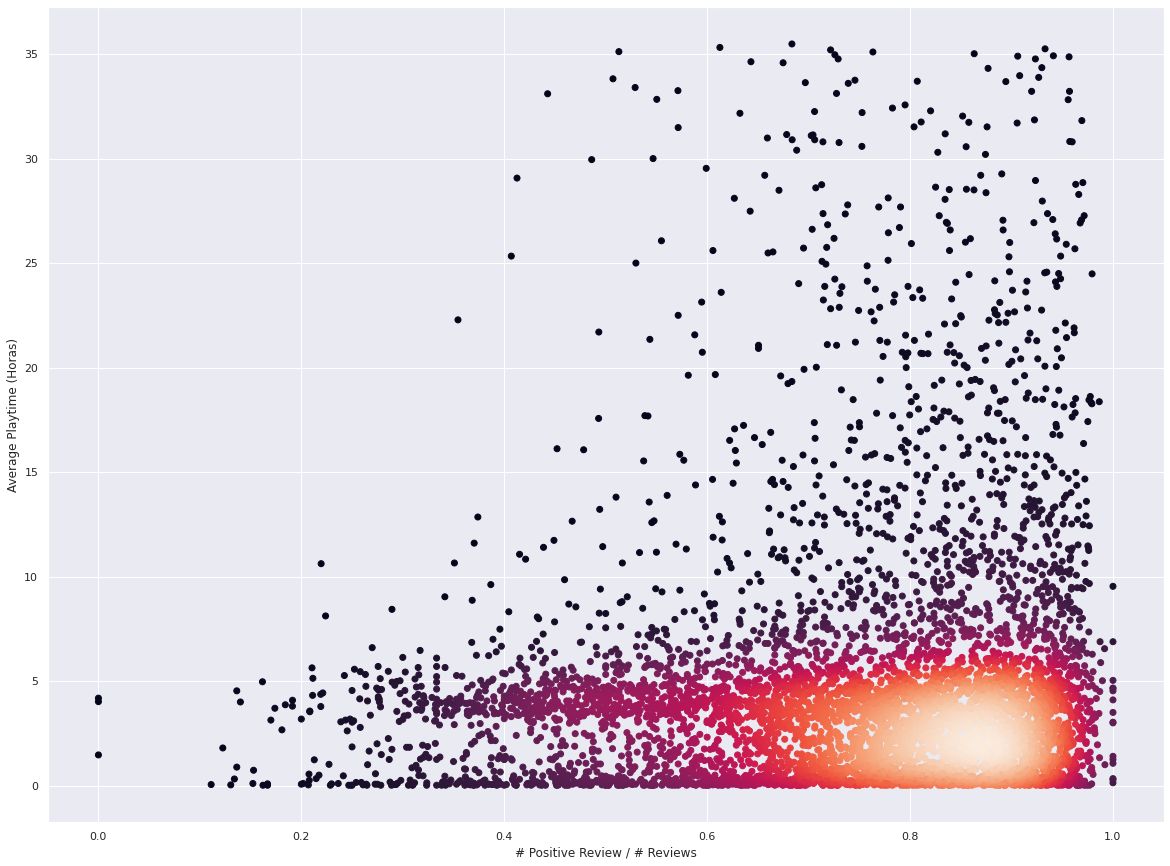

In [19]:
subdf = df[['name', 'positive_ratings', 'negative_ratings', 'average_playtime']].iloc[:, 1:]

i_max = np.percentile(subdf.average_playtime.values, 99)
i_min = np.percentile(subdf.average_playtime.values, 1)
subdf = subdf[subdf.average_playtime > i_min]
subdf = subdf[subdf.average_playtime < i_max]

subdf["rating"] = subdf.positive_ratings/(subdf.positive_ratings + subdf.negative_ratings)
subdf.replace([np.inf, -np.inf], np.nan, inplace=True)
subdf = subdf.dropna()
subdf.sort_values(by='average_playtime', ascending=False, inplace=True)

x = subdf.values[:, [3,2]]
y = np.corrcoef([x[:,0], x[:,1]/60])
print("Correlação: " + str(y[0,1]))

fig, ax = plt.subplots(figsize=(20, 15))
a = x[:,0]
b = x[:,1]

ab = np.vstack([a,b])
z = gaussian_kde(ab)(ab)

idx = z.argsort()
a, b, z = a[idx], b[idx], z[idx]

plt.scatter(a, b, c=z)

plt.xlabel('# Positive Review / # Reviews')
plt.ylabel('Average Playtime (Horas)');

## Correlação entre a razão entre o \# de avaliações positivas sobre o \# de avaliações e o número de jogadores.

Correlação: 0.10969056987508591
Correlação de Spearman: 0.0878620723007601


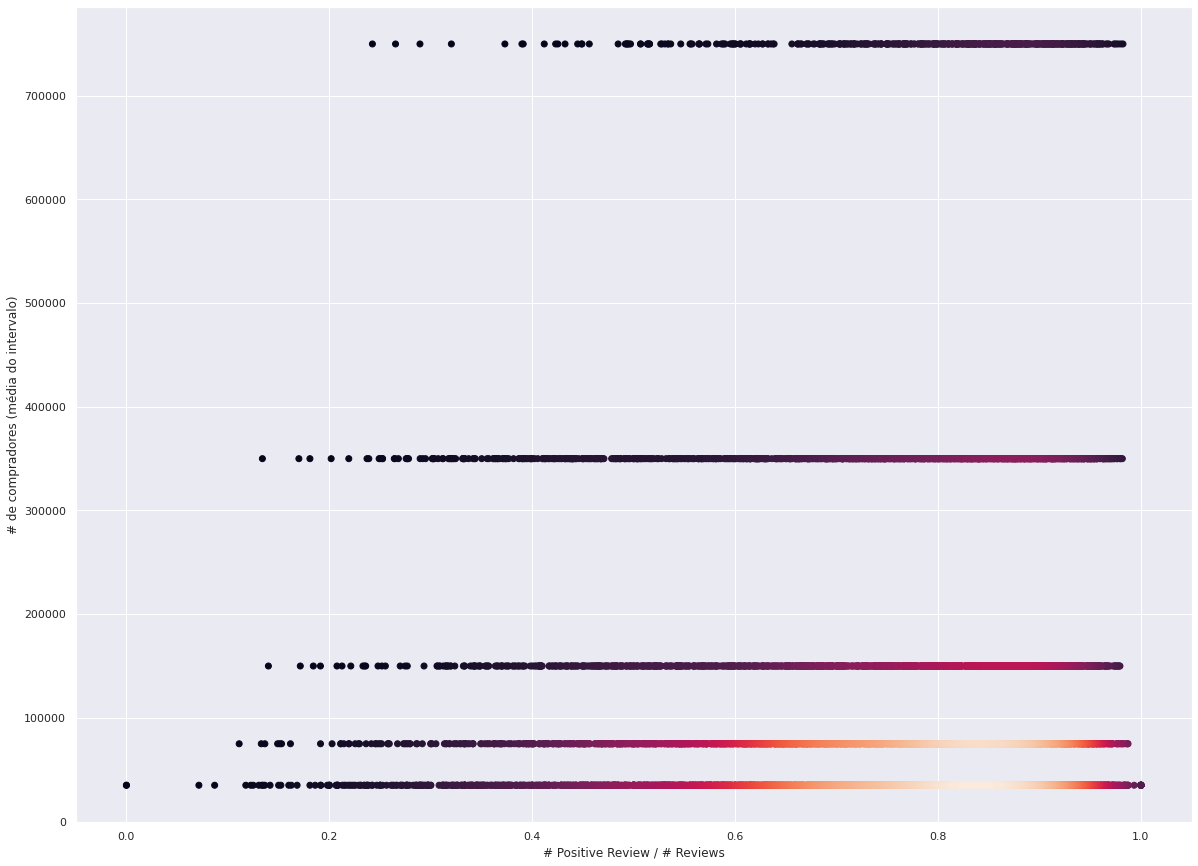

In [20]:
subdf = df[['name', 'positive_ratings', 'negative_ratings', 'owners']].iloc[:, 1:]

subdf["rating"] = subdf.positive_ratings/(subdf.positive_ratings + subdf.negative_ratings)
subdf.replace([np.inf, -np.inf], np.nan, inplace=True)
subdf['owners'] = [np.mean([int(x) for x in e.split('-') ]) for e in subdf.owners]
subdf = subdf.dropna()
subdf.sort_values(by='owners', ascending=False)[:20]

i_max = np.percentile(subdf.owners.values, 99)
i_min = np.percentile(subdf.owners.values, 1)
subdf = subdf[subdf.owners > i_min]
subdf = subdf[subdf.owners < i_max]

x = subdf.values[:, [3,2]]
y = np.corrcoef([x[:,0], x[:,1]])
print("Correlação: " + str(y[0,1]))

y = ss.spearmanr(x[:,0], x[:,1])
print("Correlação de Spearman: " + str(y[0]))

fig, ax = plt.subplots(figsize=(20, 15))

a = x[:,0]
b = x[:,1]

ab = np.vstack([a,b])
z = gaussian_kde(ab)(ab)

idx = z.argsort()
a, b, z = a[idx], b[idx], z[idx]

plt.scatter(a, b, c=z)

plt.xlabel('# Positive Review / # Reviews')
plt.ylabel('# de compradores (média do intervalo)');

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Correlação (media do intervalo de rating e mediana do número de jogadores): 0.7772670967005149


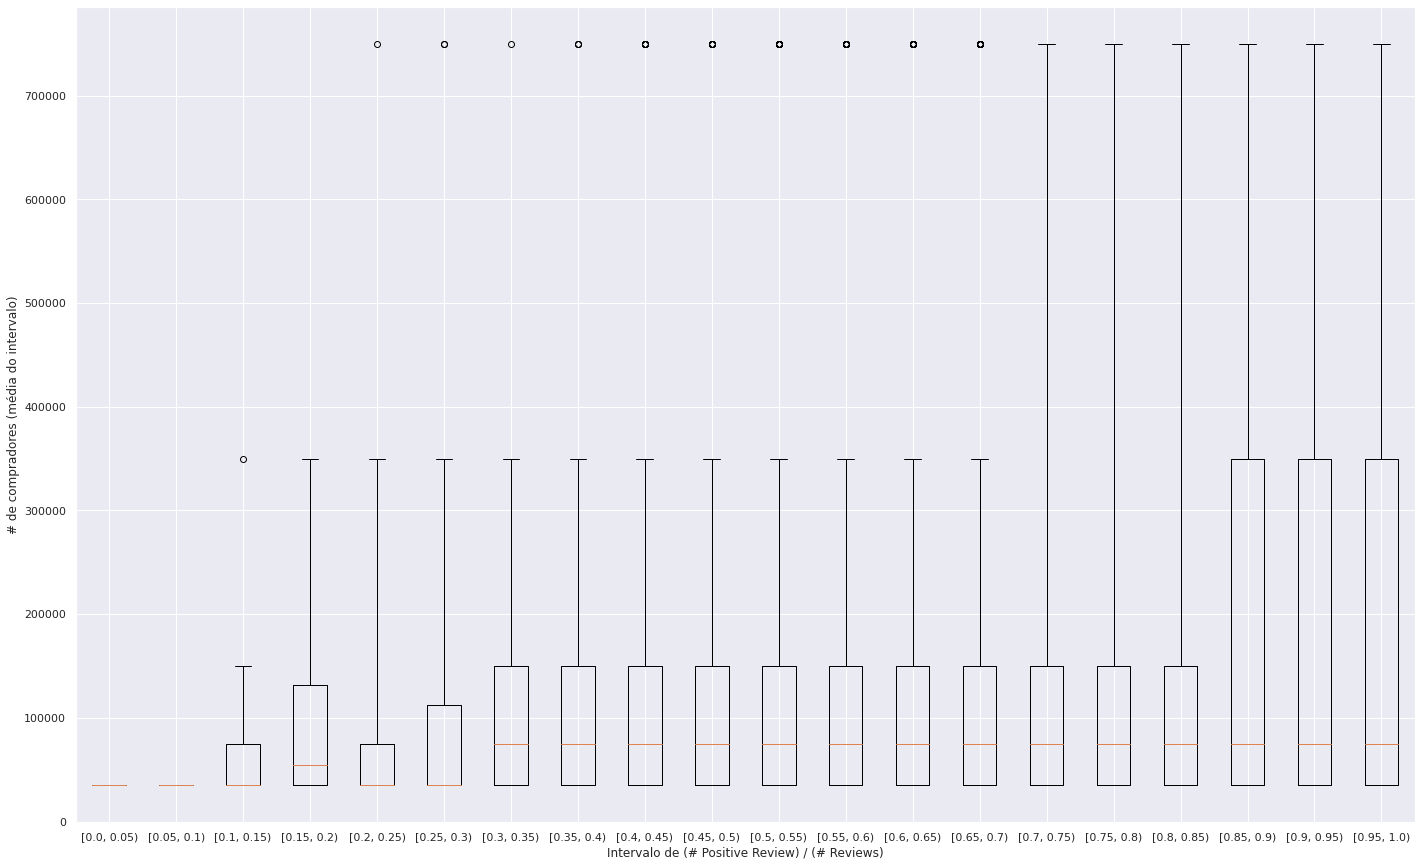

In [21]:
sub_df = pd.DataFrame(x, columns=['Rating', 'Owners'])
groups = sub_df.groupby(pd.cut(sub_df['Rating'], np.arange(0, 1.0+0.05, 0.05), right=False))

fig, ax = plt.subplots(figsize=(24,15))
data = dict()
for i in np.arange(0.0, 1.0, 0.05):
  l, r = round(i, 2), round(i+0.05, 2)
  if(len(groups.groups[pd.Interval(l, r, closed="left")]) > 0):
    data["[" + str(l) + ", " + str(r) + ")"] = groups.get_group(pd.Interval(l,r, closed="left"))["Owners"].values;

ax.boxplot(data.values(), whis=[5, 95], showfliers=True);
ax.set_xticklabels(data.keys());
plt.xlabel("Intervalo de (# Positive Review) / (# Reviews)")
plt.ylabel("# de compradores (média do intervalo)");

# Correlacao entre media do intervalo de preco e mediana do numero de jogadores
x_corr = []
y_corr = []
for i in np.arange(0, 1, 0.05):
  l, r = round(i, 2), round(i+0.05, 2)
  k = "[" + str(l) + ", " + str(r) + ")"
  if k in data.keys():
    x_corr += [(l + r) / 2]
    y_corr += [np.median(data[k])]

print("Correlação (media do intervalo de rating e mediana do número de jogadores): " + str(np.corrcoef(x_corr, y_corr)[0,1]))

## Correlação entre o tempo de jogo médio e o número de jogadores.

Correlação: 0.24876746827172055


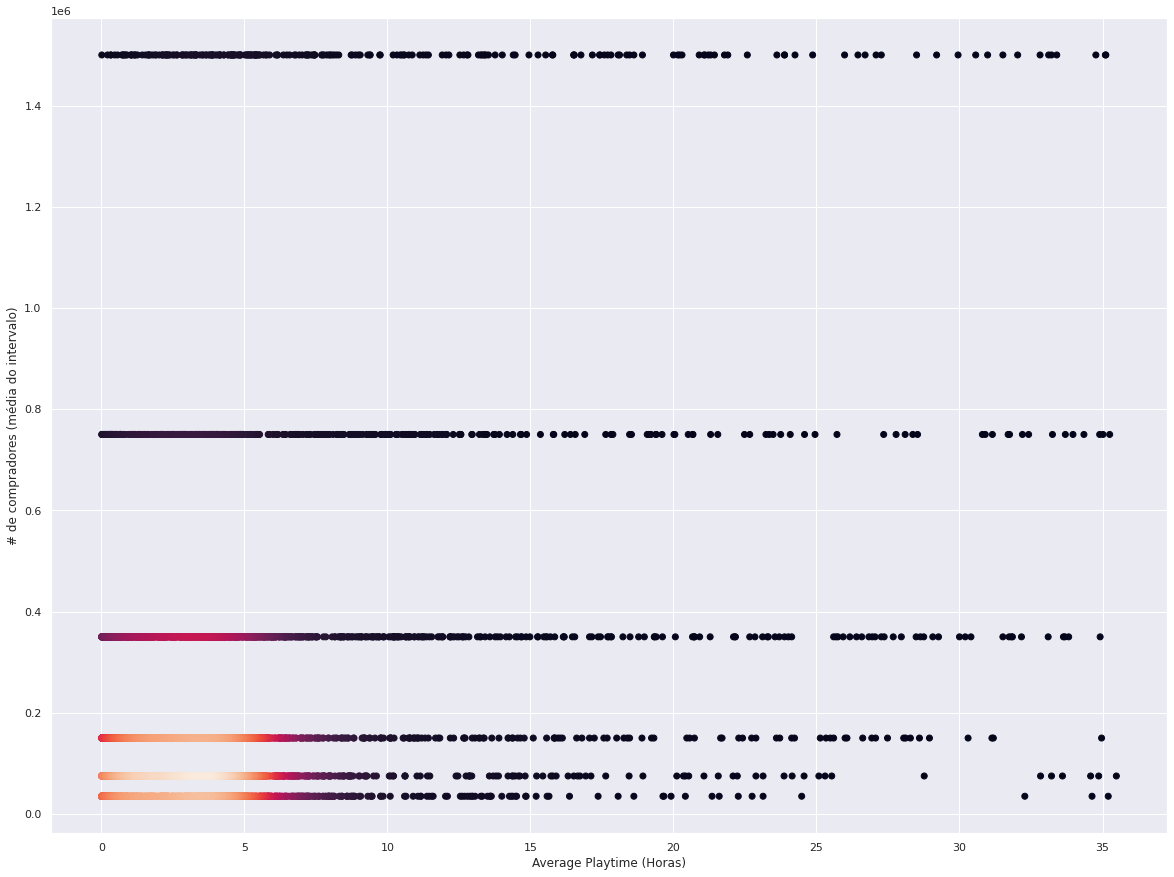

In [22]:
subdf = df[['name', 'average_playtime', 'owners']].iloc[:, 1:]

subdf['owners'] = [np.mean([int(x) for x in e.split('-') ]) for e in subdf.owners]
subdf.sort_values(by='owners', ascending=False, inplace=True)

i_max = np.percentile(subdf.average_playtime.values, 99)
i_min = np.percentile(subdf.average_playtime.values, 1)
subdf = subdf[subdf.average_playtime > i_min]
subdf = subdf[subdf.average_playtime < i_max]

i_max = np.percentile(subdf.owners.values, 99)
i_min = np.percentile(subdf.owners.values, 1)
subdf = subdf[subdf.owners > i_min]
subdf = subdf[subdf.owners < i_max]

x = subdf.values[:, [0,1]]
y = np.corrcoef([x[:,0], x[:,1]])
print("Correlação: " + str(y[0,1]))

fig, ax = plt.subplots(figsize=(20, 15))

a = x[:,0]
b = x[:,1]

ab = np.vstack([a,b])
z = gaussian_kde(ab)(ab)

idx = z.argsort()
a, b, z = a[idx], b[idx], z[idx]

plt.scatter(a, b, c=z)

plt.xlabel('Average Playtime (Horas)')
plt.ylabel('# de compradores (média do intervalo)');

achievements


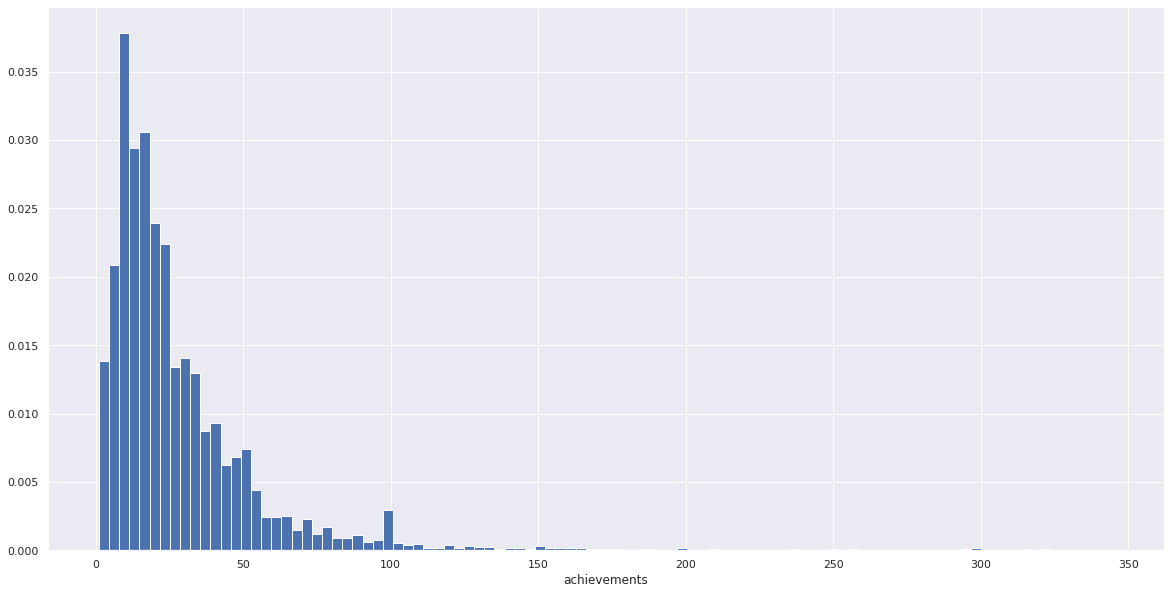






positive_ratings


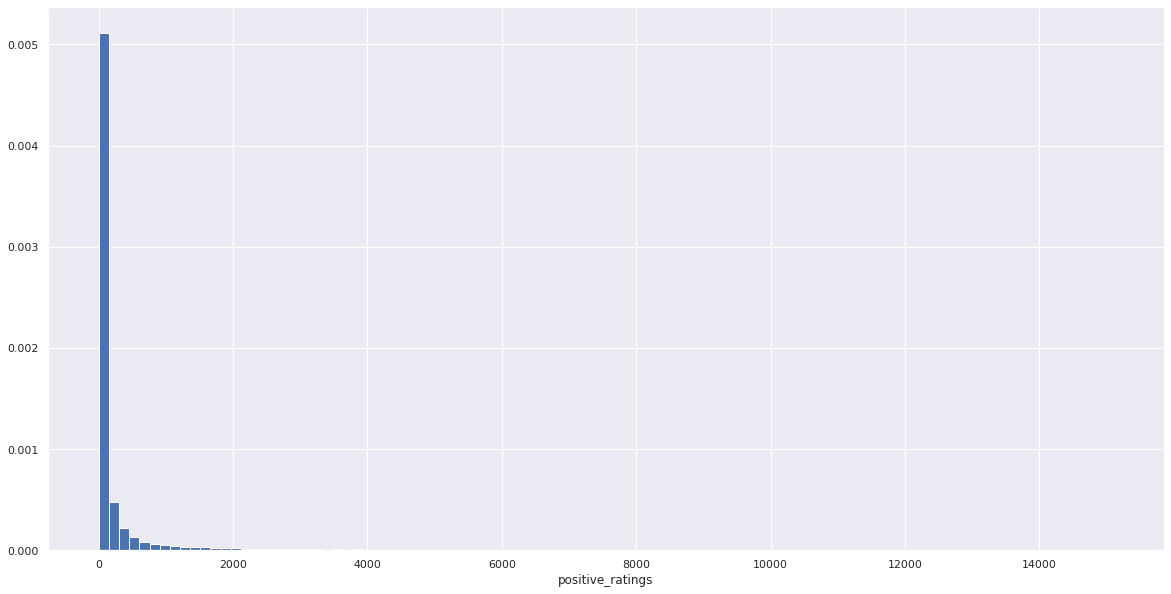






negative_ratings


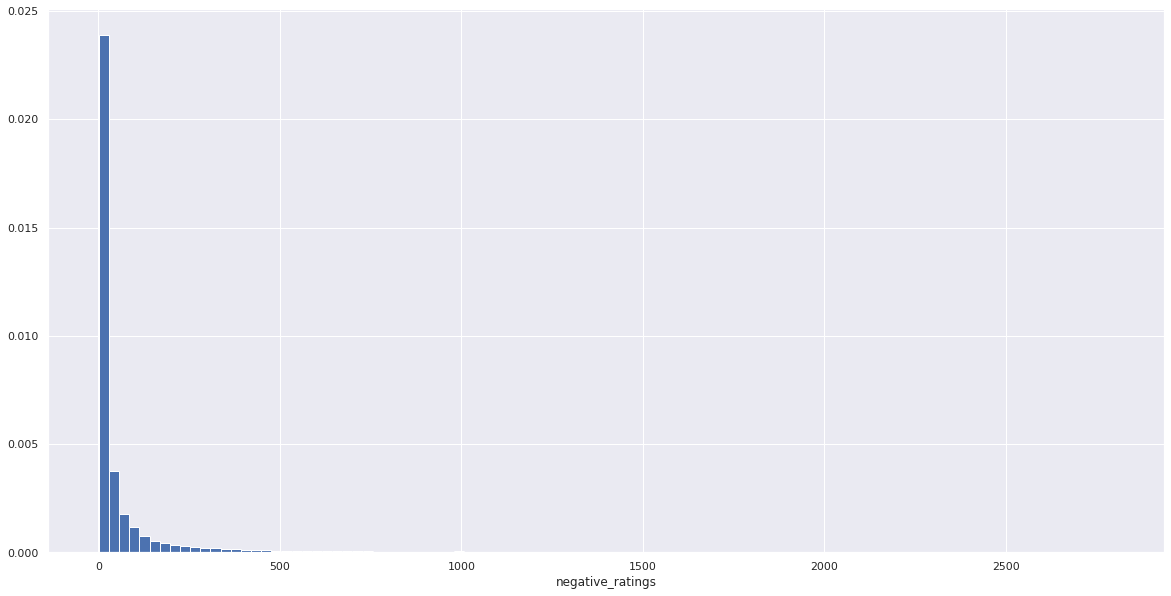






average_playtime


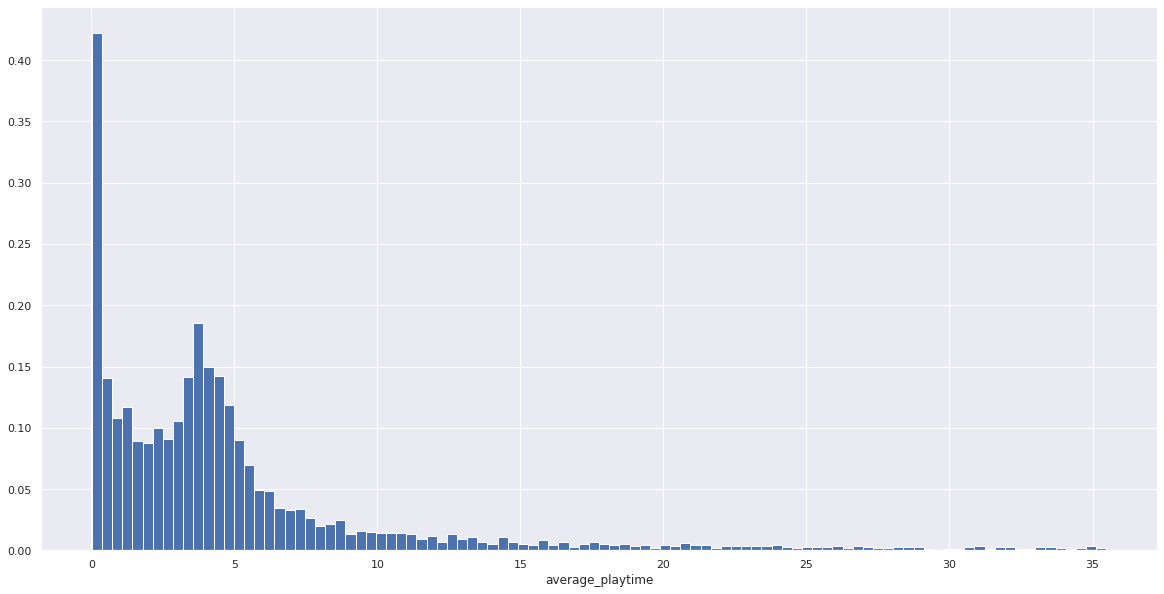






median_playtime


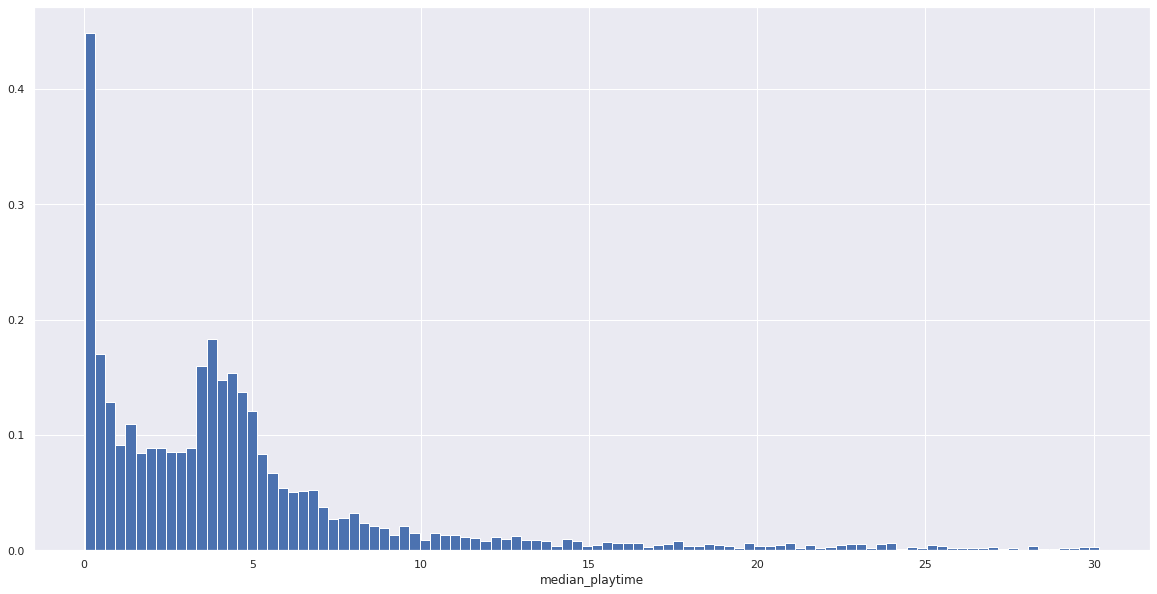






price


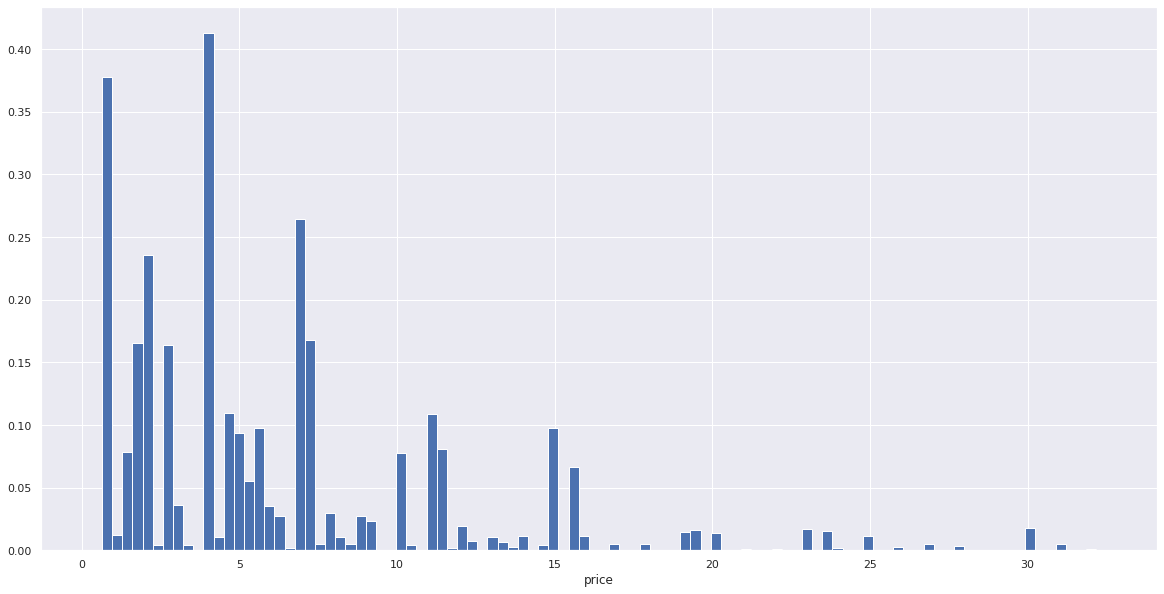

In [23]:
def reject_outliers(data, mn = 1, mx = 99):
    i_max = np.percentile(data, mx)
    i_min = np.percentile(data, mn)
    data = data[data > i_min]
    data = data[data < i_max]
    return data

columns = [
            "achievements",
            "positive_ratings",
            "negative_ratings",
            "average_playtime",
            "median_playtime",
            # "owners",
            "price"
]
for c in columns:
    print(c)
    fig = plt.figure(figsize=(20,10))
    x = reject_outliers(df[c].values)
    plt.hist(x, bins=100, density=True)
    plt.xlabel(c)
    plt.show()
    print("\n\n\n\n")

## Visualizando os dados de forma significativa

90% at x=14
95% at x=18
98% at x=26


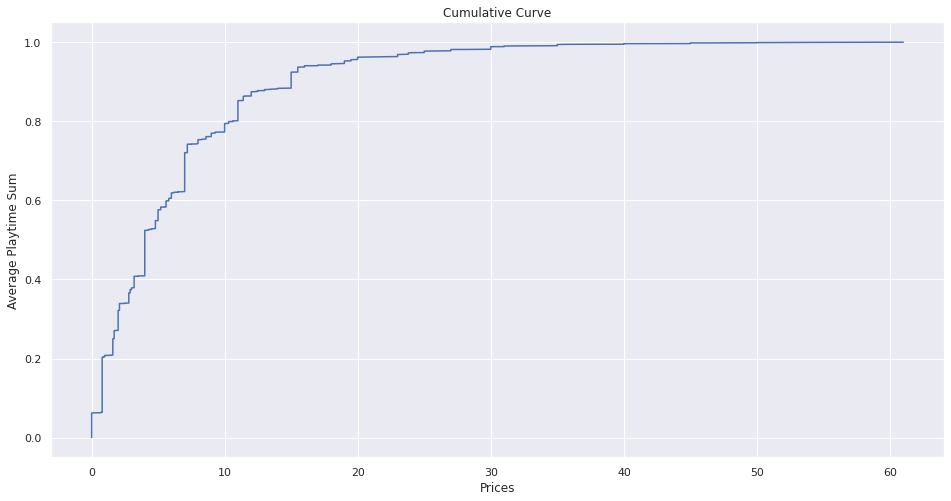

In [24]:
def cumulative_curve(interval, to_sum, name=None, point=None):
    fig = plt.figure(figsize=(16,8))
    idx = np.argsort(interval)
    sum = np.cumsum(to_sum[idx])
    sum /= max(sum)
    plt.plot(interval[idx], sum)
    if name:
        plt.xlabel(name[0])
        plt.ylabel(name[1])
        plt.title('Cumulative Curve')
    if point:
        for p in point:
            mark = interval[idx][sum > p][0]
            print('%d%% at x=%d'%(p*100, mark))

    
subdf = df[['name', 'price', 'average_playtime']]
i_max = np.percentile(subdf.average_playtime.values, 95)
i_min = np.percentile(subdf.average_playtime.values, 5)
subdf = subdf[subdf.average_playtime > i_min]
subdf = subdf[subdf.average_playtime < i_max]

x = np.asarray(subdf.values[:, 1:], dtype=np.float32)
prices = x[:,0]
avg_playtime = x[:,1]
cumulative_curve(prices, avg_playtime, ['Prices', 'Average Playtime Sum'], point=[0.9, 0.95, 0.98])

90% at x=23
95% at x=29
98% at x=39


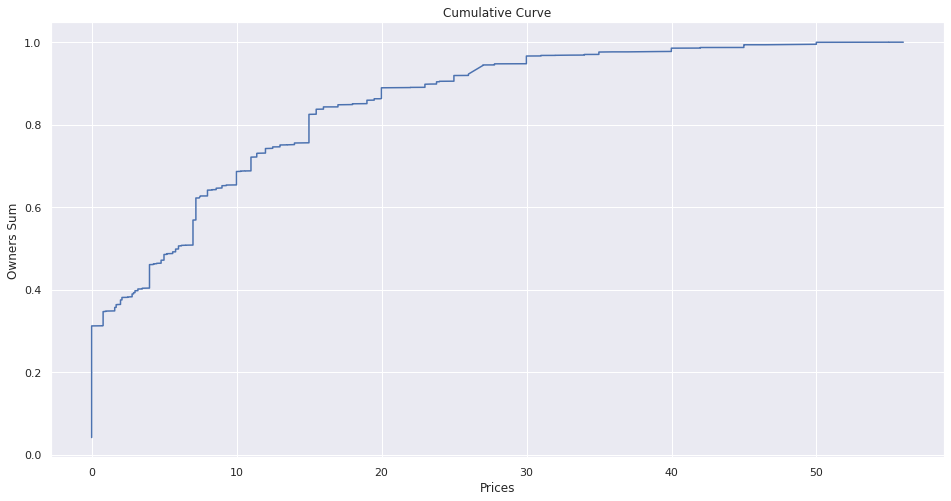

In [25]:
subdf = df[['name', 'price', 'owners']].iloc[:, 1:]

subdf['owners'] = [np.mean([int(x) for x in e.split('-') ]) for e in subdf.owners]
subdf.sort_values(by='owners', ascending=False, inplace=True)

# i_max = np.percentile(subdf.price.values, 95)
# i_min = np.percentile(subdf.price.values, 5)
# subdf = subdf[subdf.price > i_min]
# subdf = subdf[subdf.price < i_max]
subdf = subdf[subdf.price < 60]

x = subdf.values[:, [0,1]]
prices = x[:,0]
owners = x[:,1]
cumulative_curve(prices, owners, ['Prices', 'Owners Sum'], point=[0.9, 0.95, 0.98])

#**REGRESSÃO**

Dividir dataset entre treino (80%) e teste (20%)

In [26]:
mask = np.random.rand(len(df)) < 0.8
df_treino = df[mask].copy()
df_teste = df[~mask].copy()

print(df.shape)
print(df_treino.shape)
print(df_teste.shape)

(27075, 18)
(21665, 18)
(5410, 18)


## Regressão: Relação entre razão da (classificação positiva) / (positiva + negativa) e tempo de jogo médio

In [27]:
def least_squares_fit(x, y):
    correlationxy = ss.pearsonr(x, y)[0]
    beta = correlationxy * np.std(y, ddof=1) / np.std(x, ddof=1)
    alpha = np.mean(y) - beta * np.mean(x)
    return alpha, beta

In [28]:
def error(alpha, beta, x, y):
    model = beta * x + alpha
    return y - model

In [29]:
def mean_of_squared_errors(alpha, beta, x, y):
    return (error(alpha, beta, x, y) ** 2).mean()

Remove outliers de average playtime

In [30]:
df_treino.sort_values(by='average_playtime', ascending=True, inplace=True)

i_max = np.percentile(df_treino.average_playtime.values, 99)
i_min = np.percentile(df_treino.average_playtime.values, 1)
df_treino = df_treino[df_treino.average_playtime > i_min]
df_treino = df_treino[df_treino.average_playtime < i_max]

df_teste.sort_values(by='average_playtime', ascending=True, inplace=True)

i_max = np.percentile(df_teste.average_playtime.values, 99)
i_min = np.percentile(df_teste.average_playtime.values, 1)
df_teste = df_teste[df_teste.average_playtime > i_min]
df_teste = df_teste[df_teste.average_playtime < i_max]

Cria coluna com rating (razão entre # analises positivas / # total de analise)

In [31]:
df_treino["rating"] = df_treino["positive_ratings"] / (df_treino["positive_ratings"] + df_treino["negative_ratings"])
df_teste["rating"] = df_teste["positive_ratings"] / (df_teste["positive_ratings"] + df_teste["negative_ratings"])

df_treino = df_treino.dropna()
df_teste = df_teste.dropna()

### Regressão nos dados contínuos

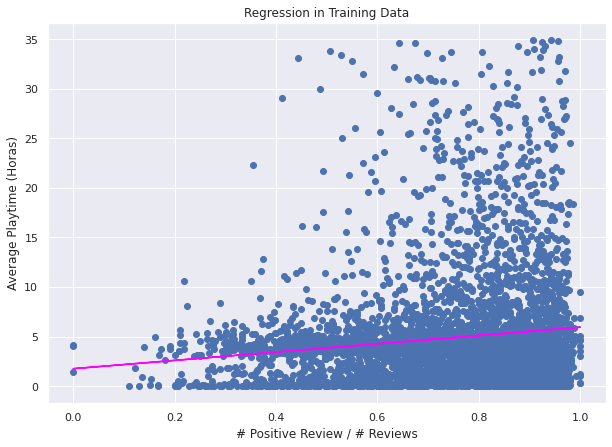

In [32]:
alpha_cont, beta_cont = least_squares_fit(df_treino["rating"], df_treino["average_playtime"])
y_model = (beta_cont * np.array(df_treino["rating"].values)) + alpha_cont

fig, ax = plt.subplots(figsize=(10, 7))
plt.scatter(df_treino["rating"].values, df_treino["average_playtime"])
plt.plot(df_treino["rating"].values, y_model, color='magenta');
plt.title("Regression in Training Data")
plt.ylabel("Average Playtime (Horas)")
plt.xlabel("# Positive Review / # Reviews");

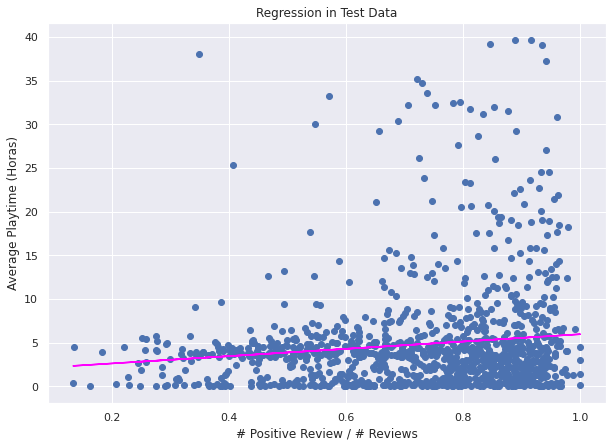

In [33]:
y_model = (beta_cont * np.array(df_teste["rating"].values)) + alpha_cont

fig, ax = plt.subplots(figsize=(10, 7))
plt.scatter(df_teste["rating"].values, df_teste["average_playtime"])
plt.plot(df_teste["rating"].values, y_model, color='magenta');
plt.title("Regression in Test Data")
plt.ylabel("Average Playtime (Horas)")
plt.xlabel("# Positive Review / # Reviews");

Calcula MSE nos dados de teste

In [34]:
MSE_con = mean_of_squared_errors(alpha_cont, beta_cont, df_teste["rating"].values, df_teste["average_playtime"].values)

Bootstrap na Regressão


In [35]:
def bootstrap_regression(df, n=1000, size=None):
    if size is None:
        size = len(df)
    
    alphas = np.zeros(n)
    betas = np.zeros(n)
    rs = np.zeros(n)

    for i in range(n):
        sample = df.sample(size, replace=True)
        x = sample['rating'].values
        y = sample['average_playtime'].values
        alpha, beta = least_squares_fit(x, y)
    
        alphas[i] = alpha
        betas[i] = beta
        rs[i] = ss.pearsonr(x, y)[0] ** 2
    return alphas, betas, rs

In [36]:
alphas, betas, rs = bootstrap_regression(df_treino)

In [37]:
def plot_histogram(data, title):
  lower = np.percentile(data, 2.5)
  upper = np.percentile(data, 97.5)
  plt.hist(data, bins=10, density=True)
  plt.title(title)
  print(title + " Mean: " + str(data.mean()))
  print(title + " Lower and Upper: " + str(lower) + " " + str(upper))

Alphas Mean: 1.7671711935983643
Alphas Lower and Upper: 1.2421102231935064 2.3044929711029134


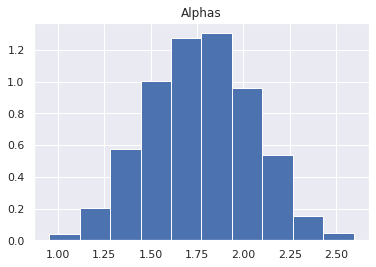

In [38]:
plot_histogram(alphas, "Alphas")

Betas Mean: 4.18274256708491
Betas Lower and Upper: 3.398432290612303 4.928263536913457


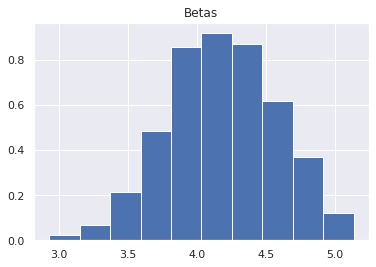

In [39]:
plot_histogram(betas, "Betas")

R2 Mean: 0.01674819403455829
R2 Lower and Upper: 0.01116473776501491 0.02297233097377478


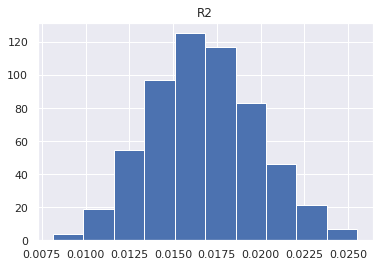

In [40]:
plot_histogram(rs, "R2")

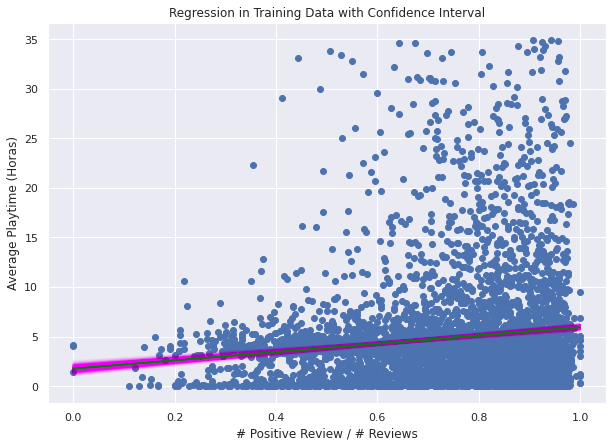

In [41]:
ys = [(betas.mean() * np.array(df_treino["rating"].values)) + alphas.mean()]
for i, alpha in enumerate(alphas):
  ys.append((betas[i] * np.array(df_treino["rating"].values)) + alpha)


fig, ax = plt.subplots(figsize=(10, 7))
plt.scatter(df_treino["rating"].values, df_treino["average_playtime"])
for yi in ys:
  plt.plot(df_treino["rating"].values, yi, color='magenta', alpha=0.01);

plt.plot(df_treino["rating"].values, ys[0], color='green', alpha=1);
plt.title("Regression in Training Data with Confidence Interval")
plt.ylabel("Average Playtime (Horas)")
plt.xlabel("# Positive Review / # Reviews");

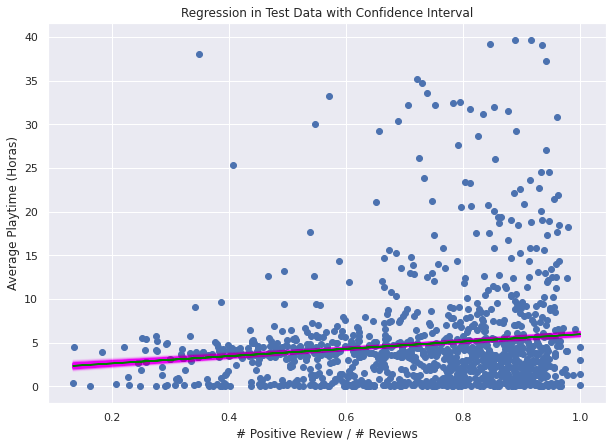

In [42]:
ys = [(betas.mean() * np.array(df_teste["rating"].values)) + alphas.mean()]
for i, alpha in enumerate(alphas):
  ys.append((betas[i] * np.array(df_teste["rating"].values)) + alpha)


fig, ax = plt.subplots(figsize=(10, 7))
plt.scatter(df_teste["rating"].values, df_teste["average_playtime"])
for yi in ys:
  plt.plot(df_teste["rating"].values, yi, color='magenta', alpha=0.01);

plt.plot(df_teste["rating"].values, ys[0], color='green', alpha=1);
plt.title("Regression in Test Data with Confidence Interval")
plt.ylabel("Average Playtime (Horas)")
plt.xlabel("# Positive Review / # Reviews");

MSE Mean: 37.70640263088631
MSE Lower and Upper: 37.662113831365154 37.79307477749588


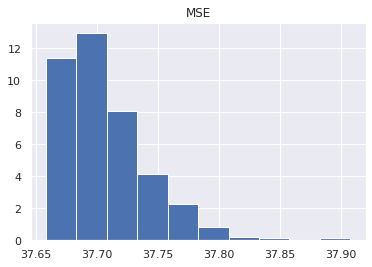

In [43]:
mse_boot = []
for i, alpha in enumerate(alphas):
  mse_boot.append(mean_of_squared_errors(alpha, betas[i], df_teste["rating"].values, df_teste["average_playtime"].values))

plot_histogram(np.array(mse_boot), "MSE")

### Regressão dos dados discretos

Discretiza os dados de rating e agrupa os dados tirando a média

In [44]:
discreto = df_treino.groupby(pd.cut(df_treino['rating'], np.arange(0, 1.0+0.05, 0.05), right=False)).mean()
rating = pd.Series(discreto.index).transform(lambda x: (x.left + x.right) / 2)
playtime = discreto["average_playtime"]

discreto_teste = df_teste.groupby(pd.cut(df_teste['rating'], np.arange(0, 1.0+0.05, 0.05), right=False)).mean()
rating_teste = pd.Series(discreto_teste.index).transform(lambda x: (x.left + x.right) / 2)
playtime_teste = discreto_teste["average_playtime"]

mask = playtime.isna().values
rating = rating[~mask]
playtime = playtime[~mask]

mask_teste = playtime_teste.isna().values
rating_teste = rating_teste[~mask_teste]
playtime_teste = playtime_teste[~mask_teste]

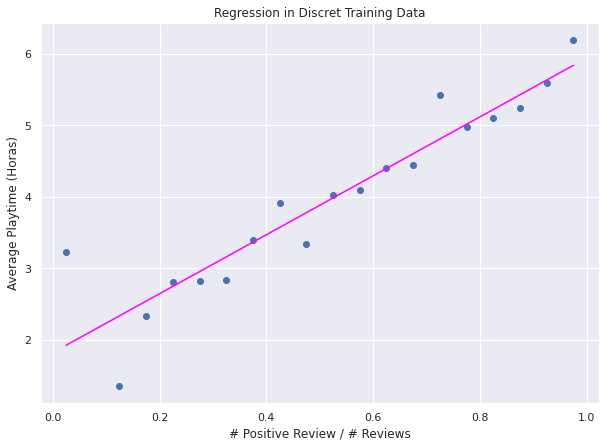

In [45]:
alpha_disc, beta_disc = least_squares_fit(rating.values, playtime.values)
y_model = (beta_disc * np.array(rating.values)) + alpha_disc

fig, ax = plt.subplots(figsize=(10, 7))
plt.scatter(rating.values, playtime.values)
plt.plot(rating.values, y_model, color='magenta');
plt.title("Regression in Discret Training Data")
plt.ylabel("Average Playtime (Horas)")
plt.xlabel("# Positive Review / # Reviews");

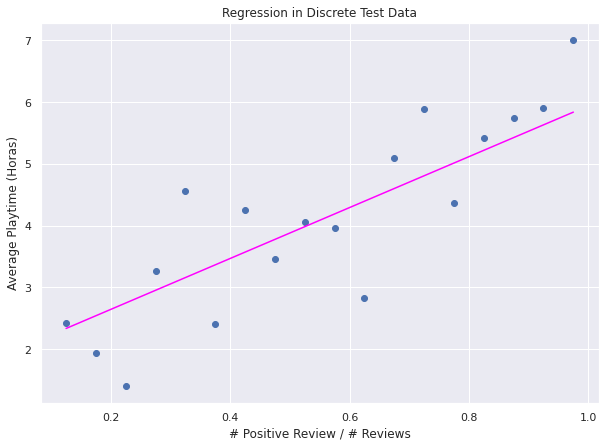

In [46]:
y_model = (beta_disc * np.array(rating_teste.values)) + alpha_disc

fig, ax = plt.subplots(figsize=(10, 7))
plt.scatter(rating_teste.values, playtime_teste.values)
plt.plot(rating_teste.values, y_model, color='magenta');
plt.title("Regression in Discrete Test Data")
plt.ylabel("Average Playtime (Horas)")
plt.xlabel("# Positive Review / # Reviews");

Calcula MSE nos dados de teste

In [47]:
MSE_dis = mean_of_squared_errors(alpha_disc, beta_disc, np.array(rating_teste.values), np.array(playtime_teste.values))

In [48]:
print("Alpha, Beta e MSE dos dados continuos: " + str(alpha_cont) + ", " + str(beta_cont) + ", " + str(MSE_con))
print("Alpha e Beta dos dados discretos: " + str(alpha_disc) + ", " + str(beta_disc) + ", " + str(MSE_dis))

Alpha, Beta e MSE dos dados continuos: 1.7625654803490591, 4.188194321725893, 37.69465459276482
Alpha e Beta dos dados discretos: 1.8195473766428596, 4.120984230286754, 0.6475606501522588


Bootstrap na Regressão

In [49]:
discrete_df = pd.DataFrame([rating.values, playtime.values], columns=["rating", "average_playtime"])
discrete_df

alphas, betas, rs = bootstrap_regression(discrete_df)

Alphas Mean: 1.7940750845846443
Alphas Lower and Upper: 1.1556880851693019 2.452733160756235


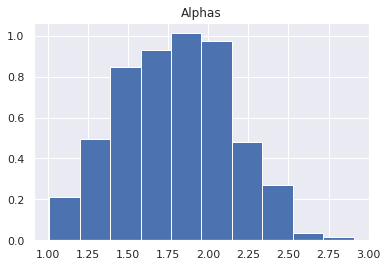

In [50]:
plot_histogram(alphas, "Alphas")

Betas Mean: 4.152419239381864
Betas Lower and Upper: 3.1415751083353096 5.094523640430604


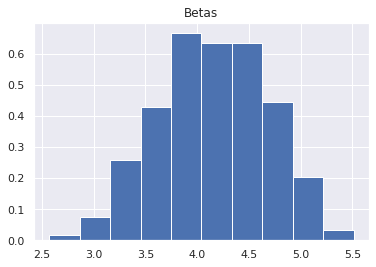

In [51]:
plot_histogram(betas, "Betas")

R2 Mean: 0.8830443621537631
R2 Lower and Upper: 0.7491627159572832 0.9732976583039316


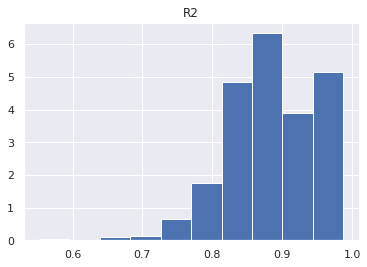

In [52]:
plot_histogram(rs, "R2")

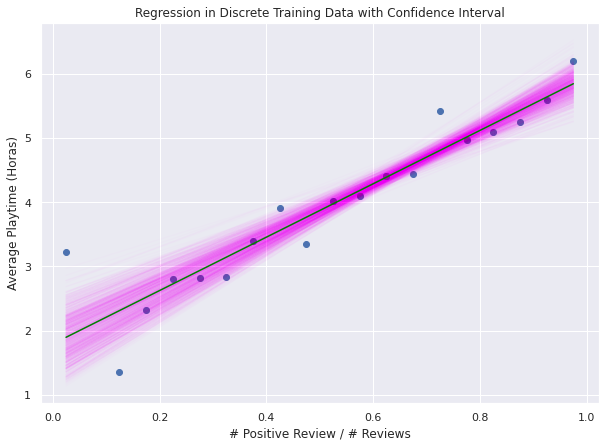

In [53]:
ys = [(betas.mean() * np.array(rating.values)) + alphas.mean()]
for i, alpha in enumerate(alphas):
  ys.append((betas[i] * np.array(rating.values)) + alpha)


fig, ax = plt.subplots(figsize=(10, 7))
plt.scatter(rating.values, playtime.values)
for yi in ys:
  plt.plot(rating.values, yi, color='magenta', alpha=0.01);

plt.plot(rating.values, ys[0], color='green', alpha=1);
plt.title("Regression in Discrete Training Data with Confidence Interval")
plt.ylabel("Average Playtime (Horas)")
plt.xlabel("# Positive Review / # Reviews");

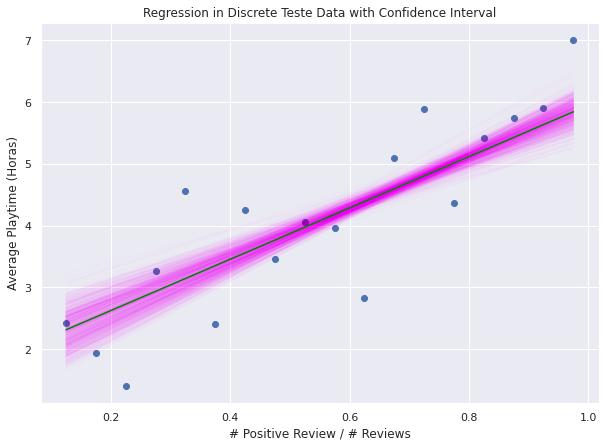

In [54]:
ys = [(betas.mean() * np.array(rating_teste.values)) + alphas.mean()]
for i, alpha in enumerate(alphas):
  ys.append((betas[i] * np.array(rating_teste.values)) + alpha)


fig, ax = plt.subplots(figsize=(10, 7))
plt.scatter(rating_teste.values, playtime_teste.values)
for yi in ys:
  plt.plot(rating_teste.values, yi, color='magenta', alpha=0.01);

plt.plot(rating_teste.values, ys[0], color='green', alpha=1);
plt.title("Regression in Discrete Teste Data with Confidence Interval")
plt.ylabel("Average Playtime (Horas)")
plt.xlabel("# Positive Review / # Reviews");

MSE Mean: 0.22638769087075145
MSE Lower and Upper: 0.19579214297410388 0.3098086363765125


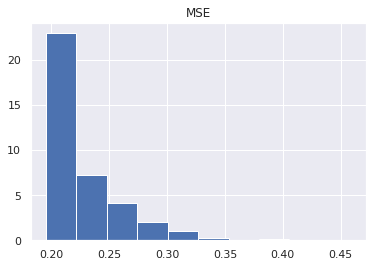

In [55]:
mse_boot = []
for i, alpha in enumerate(alphas):
  mse_boot.append(mean_of_squared_errors(alpha, betas[i], np.array(rating.values), np.array(playtime.values)))

plot_histogram(np.array(mse_boot), "MSE")

## Regressão: Relação entre razão de (classificação positiva) / (positiva + negativa) com Tempo de Jogo Médio para Preço

Realiza normalização

In [56]:
scaler = StandardScaler()
df_treino_scaled = scaler.fit_transform(df_treino[["rating", "average_playtime"]])
df_treino_scaled = pd.DataFrame(df_treino_scaled, columns=["rating", "average_playtime"])
df_treino_scaled["price"] = df_treino["price"].values
df_treino_scaled.head()

,rating,average_playtime,price
0,-0.268486,-0.844388,0.00
1,0.842467,-0.844388,3.99
2,-1.336867,-0.844388,0.00
3,1.196469,-0.844388,1.59
4,-0.093670,-0.844388,2.89


Faz Bootstrap da Regressão

In [57]:
def bootstrap_regression(df, n=1000, size=None):
    if size is None:
        size = len(df)
    
    regs = [0]*n
    rs = np.zeros(n)

    for i in range(n):
        sample = df.sample(size, replace=True)
        x = sample[["rating", "average_playtime"]].values
        y = sample["price"].values
        reg = LinearRegression().fit(x, y)
    
        regs[i] = reg
        rs[i] = reg.score(x, y)
    return regs, rs

In [58]:
regs, rs = bootstrap_regression(df_treino_scaled)

R2 Mean: 0.1499452640129786
R2 Lower and Upper: 0.12448635653733817 0.1753656715564737


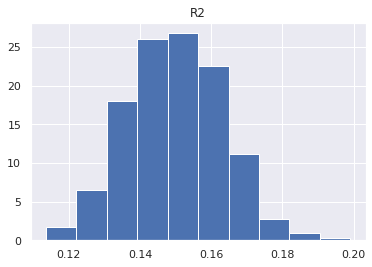

In [59]:
plot_histogram(rs, "R2")

Aplica regressão no teste

In [60]:
df_teste_scaled = scaler.transform(df_teste[["rating", "average_playtime"]])
df_teste_scaled = pd.DataFrame(df_teste_scaled, columns=["rating", "average_playtime"])
df_teste_scaled["price"] = df_teste["price"].values
df_teste_scaled.head()

,rating,average_playtime,price
0,-2.773653,-0.844388,0.00
1,-0.572513,-0.844388,0.00
2,-0.796527,-0.844388,4.49
3,-0.947770,-0.844388,0.79
4,-0.785940,-0.844388,0.79


In [61]:
def mean_of_squared_errors(y_hat, y):
    return ((y_hat - y) ** 2).mean()

In [62]:
MSE = []
for reg in regs:
  MSE.append(mean_of_squared_errors(reg.predict(df_teste_scaled[["rating", "average_playtime"]].values), df_teste_scaled["price"].values))

MSE Mean: 52.71698648764302
MSE Lower and Upper: 52.229119847360906 53.5214526652144


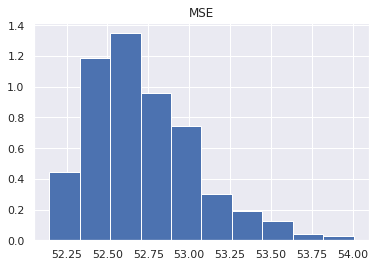

In [63]:
plot_histogram(np.array(MSE), "MSE")

# **TESTES DE HIPÓTESE**

## Hipótese:  Os jogos RPG tem maior tempo de jogo que os jogos de Ação?

In [64]:
count = dict()
for _,e in df[["genres", "average_playtime"]].iterrows():
    for d in e.genres.split(';'):
        if not d in count.keys():
            count[d] = []
        count[d] += [e.average_playtime]

In [65]:
action = pd.DataFrame((count["Action"]), columns=['average_playtime'])
rpg = pd.DataFrame((count["RPG"]), columns=['average_playtime'])
baseline_diff = rpg.mean() - action.mean()
print('Diferença: ', baseline_diff)
rpg['label'] = 0
action['label'] = 1
df0 = action.append(rpg);

Diferença:  average_playtime    2.216154
dtype: float64


### Sem filtrar os outliers

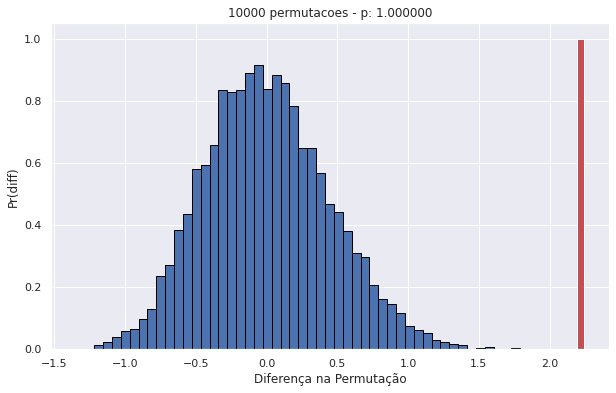

In [66]:
np.random.seed(42)
labels = df0["label"].values.copy()
val = df0['average_playtime'].values.copy()

j = 10000
diffs = []
for i in range(j):
    np.random.shuffle(labels)
    m = [val[labels == l].mean() for l in [0, 1]]
    diffs.append( m[0] - m[1])

fig, ax = plt.subplots(figsize=(10,6))
ax.hist(diffs, bins=50, density=True, edgecolor='black')
ax.bar(baseline_diff, 1.0, width=0.05, color='r')
ax.set_xlabel('Diferença na Permutação')
ax.set_ylabel('Pr(diff)')
pval = sum( np.array(diffs) < float(baseline_diff))/len(diffs)
plt.title('%d permutacoes - p: %f'%(j, pval))
plt.show()


### Filtrando os outliers

In [67]:
action = pd.DataFrame((count["Action"]), columns=['average_playtime'])
rpg = pd.DataFrame((count["RPG"]), columns=['average_playtime'])
action = action[action.average_playtime < action.average_playtime.quantile(0.975)]
action = action[action.average_playtime > action.average_playtime.quantile(0.025)]
rpg = rpg[rpg.average_playtime < rpg.average_playtime.quantile(0.975)]
rpg = rpg[rpg.average_playtime > rpg.average_playtime.quantile(0.025)]


baseline_diff = rpg.mean() - action.mean()
print('Diferença: ', baseline_diff)
rpg['label'] = 0
action['label'] = 1
df0 = action.append(rpg);

Diferença:  average_playtime    2.204206
dtype: float64


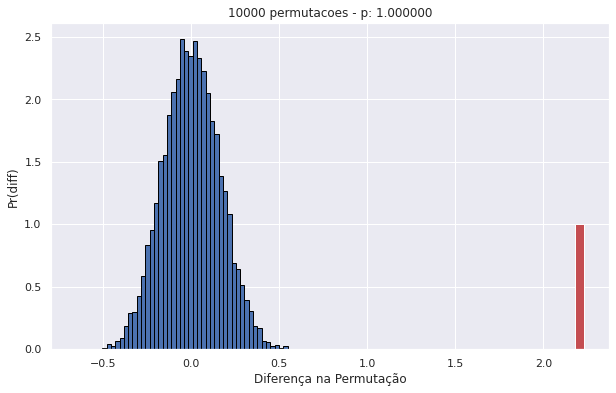

In [68]:
np.random.seed(42)
labels = df0["label"].values.copy()
val = df0['average_playtime'].values.copy()

j = 10000
diffs = []
for i in range(j):
    np.random.shuffle(labels)
    m = [val[labels == l].mean() for l in [0, 1]]
    diffs.append( m[0] - m[1])

fig, ax = plt.subplots(figsize=(10,6))
ax.hist(diffs, bins=50, density=True, edgecolor='black')
ax.bar(baseline_diff, 1.0, width=0.05, color='r')
ax.set_xlabel('Diferença na Permutação')
ax.set_ylabel('Pr(diff)')
pval = sum( np.array(diffs) < float(baseline_diff))/len(diffs)
plt.title('%d permutacoes - p: %f'%(j, pval))
plt.show()

## **Hipótese:  Os top jogos mais bem avaliados tem tempo de jogo maior que os top jogos mais mal avaliados?**


In [69]:
df0 = df[["positive_ratings", "negative_ratings", "average_playtime"]]
df0['rating'] = df["positive_ratings"]/(df["positive_ratings"]+df["negative_ratings"])
df0 = df0.dropna(how='all')
val = 0.30
pos = df0[df0.rating > df0.rating.quantile(1-val)]
neg = df0[df0.rating < df0.rating.quantile(val)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
baseline_diff = pos.average_playtime.mean() - neg.average_playtime.mean()
print('Diferença: ', baseline_diff)
neg['label'] = 1
pos['label'] = 0
df0 = pos.append(neg)

Diferença:  1.101146491792436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


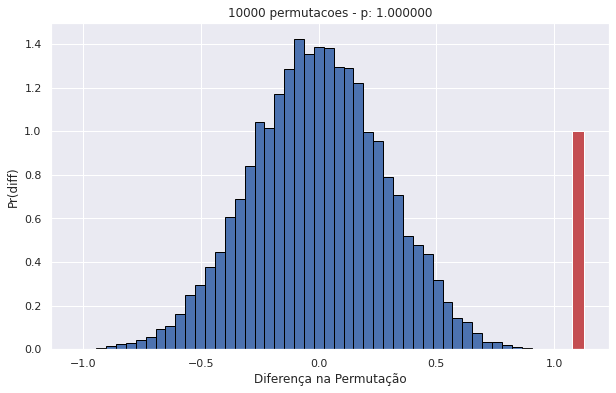

In [71]:
np.random.seed(42)
labels = df0["label"].values.copy()
val = df0['average_playtime'].values.copy()

j = 10000
diffs = []
for i in range(j):
    np.random.shuffle(labels)
    m = [val[labels == l].mean() for l in [0, 1]]
    diffs.append( m[0] - m[1])

fig, ax = plt.subplots(figsize=(10,6))
ax.hist(diffs, bins=50, density=True, edgecolor='black')
ax.bar(baseline_diff, 1.0, width=0.05, color='r')
ax.set_xlabel('Diferença na Permutação')
ax.set_ylabel('Pr(diff)')
pval = sum( np.array(diffs) < float(baseline_diff))/len(diffs)
plt.title('%d permutacoes - p: %f'%(j, pval))
plt.show()

#**INTERVALOS DE CONFIANÇA**

##Average Playtime

Obtemos uma amostra aleatória de 30% dos dados

In [72]:
nme = df['average_playtime']
nme = nme[nme < nme.quantile(0.975)]
nme = nme[nme > nme.quantile(0.025)]
msk = np.random.rand(len(nme)) < 0.3
nme1 = nme[msk].copy()
N = 5000

Para esta amosta, realizamos um Bootstrap com 5000 iterações para obter o intervalo de confiança da média dos valores de Average Playtime

Intervalo de confiança para 95%: [3.385091832747173, 3.6794275107463825]


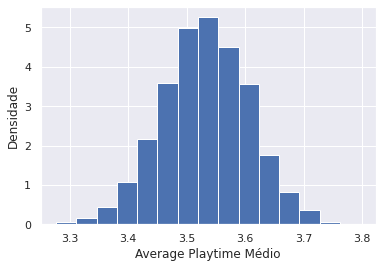

In [73]:
def bootstrap_mean(nme, n):
    size = len(nme)
    values = np.zeros(n)
    for i in range(n):
        sample = nme.sample(size, replace=True)
        values[i] = sample.mean()
    return values

bm_values = bootstrap_mean(nme1, N)
plt.xlabel("Average Playtime Médio")
plt.ylabel("Densidade")
plt.hist(bm_values, density=True, bins=15)

def percentile(bm_values, init, final):
    inferior = np.percentile(bm_values, init)
    superior = np.percentile(bm_values, final)
    return [inferior, superior]

result1 = percentile(bm_values, 2.5, 97.5)
print("Intervalo de confiança para 95%: " + str(result1))

Agora, são obtidas mais 1000 amostras aleatórias do conjunto total de dados, também de 30% dos dados, e é verificado quantas delas possuem média de valores de Average Playtime dentro do intervalo calculado

In [74]:
nme2 = nme[~msk].copy()
c = 0
for i in range(1000):
  x = nme2.sample(n = len(nme1), replace=False).mean()
  if (x > result1[0] and x < result1[1]):
    c += 1
print("Procentagem de amostras dentro do IC calculado: " + str(c/10) + "%")

Procentagem de amostras dentro do IC calculado: 96.5%


##Rating

O mesmo processo descrito acima é repetido, porém agora com a média de valores de rating (# de avaliações positivas / # total de avaliações) dos jogos

Intervalo de confiança para 95%: [0.7090879270446384, 0.7194112338796296]


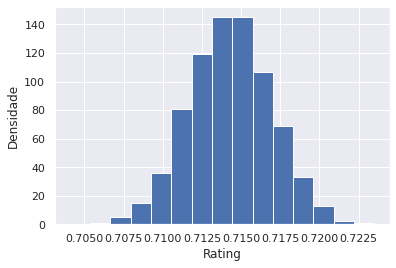

In [75]:
smp1 = df['positive_ratings']
smp2 = df['negative_ratings']
smp = (smp1/(smp1+smp2))
msk = np.random.rand(len(smp)) < 0.3
nme3 = smp[msk].copy()
bm_values2 = bootstrap_mean(nme3, N)
plt.xlabel("Rating")
plt.ylabel("Densidade")
plt.hist(bm_values2, density=True, bins=15)
result2 = percentile(bm_values2, 2.5, 97.5)
print("Intervalo de confiança para 95%: " + str(result2))

In [76]:
nme4 = smp[~msk].copy()
c = 0
for i in range(1000):
  x = nme4.sample(n = len(nme3), replace=False).mean()
  if (x > result2[0] and x < result2[1]):
    c += 1
print("Procentagem de amostras dentro do IC calculado: " + str(c/10) + "%")

Procentagem de amostras dentro do IC calculado: 99.1%


Dado que a base escolhida é quantitativamente representativa, gostaríamos de saber como uma parcela dos dados generaliza para o todo. Para tal utilizamos a técnica de boostrap a fim de computar intervalos de confiança. O atributo escolhido foi o Rating, definido como as avaliações positivas sobre o total de avaliações.

Para o cálculo do intervalo de confiança selecionamos 30% do conjunto de dados total e aplicamos Bootstrap com 5000 iterações, obtendo um intervalo de 0.70-0.72 para o rating. Feito isso, selecionamos 1000 amostras aleatórias dos dados restantes com o objetivo de checar se estes estariam dentro do intervalo de confiança. Os resultados mostraram que 99% dos dados caem dentro deste intervalo.

#**CLASSIFICAÇÃO**


In [77]:
# imports
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [78]:
# Usaremos rating, average_playtime, median_playtime, owners, price para classificar os cincos generos mais presentes
# Filtragem dos dados

df_cls = df[df.genres.isin(['Action', 'Indie', 'Adventure', 'Free to Play', 'Strategy'])]
y = df_cls.genres
df_cls = df_cls[['average_playtime', 'median_playtime', 'owners', 'price']]
df_cls.owners = df_cls.loc[:]['owners'].str.split('-')
df_cls.owners = (df_cls.loc[:]['owners'].str[0].astype(int)+ df_cls.loc[:]['owners'].str[1].astype(int))/2
df_cls['rating'] = df.positive_ratings/(df.positive_ratings+df.negative_ratings)
X = df_cls

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [80]:
scaler = StandardScaler()
X_new_train = scaler.fit_transform(X_train)
y_new_train = pd.get_dummies(y_train)
X_new_test = (X_test - X_train.mean()) / X_train.std(ddof=1)
bt_df = X_new_test.copy()
bt_df['label'] = y_test # DataFrame para calcular bootstrap

## Logistic Regression

In [81]:
lr_model = LogisticRegressionCV(Cs=100, fit_intercept=True,
                             cv=3,
                             multi_class='ovr',
                             penalty='l2',
                             solver='liblinear')
lr_model.fit(X_new_train, y_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv=3, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)

In [82]:
print(classification_report(y_test, lr_model.predict(X_new_test)))

              precision    recall  f1-score   support

      Action       0.55      0.11      0.18       157
   Adventure       0.23      0.90      0.36       111
Free to Play       0.00      0.00      0.00         5
       Indie       0.56      0.21      0.31       151
    Strategy       0.33      0.02      0.04       107

    accuracy                           0.28       531
   macro avg       0.33      0.25      0.18       531
weighted avg       0.44      0.28      0.22       531



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
N = 5000

def bootstrap_acc(df, n):
    size = len(df)
    values = np.zeros(n)
    for i in range(n):
        sample = df.sample(size, replace=True)
        values[i] = accuracy_score(sample.iloc[:,-1], lr_model.predict(sample.iloc[:,:5]))
    return values

bm_values = bootstrap_acc(bt_df, N)

def percentile(bm_values, init, final):
    inferior = np.percentile(bm_values, init)
    superior = np.percentile(bm_values, final)
    return [inferior, superior]

result1 = percentile(bm_values, 2.5, 97.5)
print(result1)

[0.2448210922787194, 0.3239171374764595]


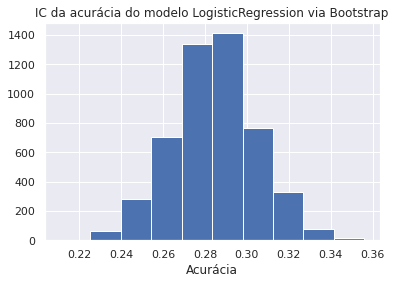

In [84]:
plt.hist(bm_values)
plt.title("IC da acurácia do modelo LogisticRegression via Bootstrap")
plt.xlabel("Acurácia")
plt.show()

## K Neighbors Classifier

In [85]:
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

In [86]:
fold = 0
melhores = []
for treino, validacao in skf.split(X_new_train, y_train.values):
    X_tt = X_new_train[treino]
    y_tt = y_train.values[treino]
    X_v = X_new_train[validacao]
    y_v = y_train.values[validacao]
    # print(len(treino),len(X_tt), len(y_tt))

    best = (0, 0)
    for nn in [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100]: # Vamos testar tais valores de n
        model = KNeighborsClassifier(n_neighbors=nn)
        model.fit(X_tt, y_tt) # treina no conjunto de treino
        y_pv = model.predict(X_v) # previsões no conjunto de validação
        
        # Resultado com melhor acurácia!
        accuracy = accuracy_score(y_v, y_pv)
        if accuracy > best[0]:
            best = (accuracy, nn)
    
    melhores.append(best[1])
    fold += 1
    print('Fold-{}, melhor n = {}, acc = {}'.format(fold, best[1], best[0]))

Fold-1, melhor n = 9, acc = 0.3925233644859813
Fold-2, melhor n = 6, acc = 0.4766355140186916
Fold-3, melhor n = 20, acc = 0.4953271028037383
Fold-4, melhor n = 10, acc = 0.44339622641509435
Fold-5, melhor n = 40, acc = 0.5188679245283019
Fold-6, melhor n = 30, acc = 0.4811320754716981
Fold-7, melhor n = 10, acc = 0.46226415094339623
Fold-8, melhor n = 30, acc = 0.4716981132075472
Fold-9, melhor n = 4, acc = 0.4528301886792453
Fold-10, melhor n = 50, acc = 0.49056603773584906
Fold-11, melhor n = 20, acc = 0.5094339622641509
Fold-12, melhor n = 40, acc = 0.46226415094339623
Fold-13, melhor n = 7, acc = 0.5
Fold-14, melhor n = 20, acc = 0.5188679245283019
Fold-15, melhor n = 5, acc = 0.4811320754716981
Fold-16, melhor n = 5, acc = 0.37735849056603776
Fold-17, melhor n = 9, acc = 0.4716981132075472
Fold-18, melhor n = 30, acc = 0.5188679245283019
Fold-19, melhor n = 8, acc = 0.4528301886792453
Fold-20, melhor n = 9, acc = 0.39622641509433965


Text(0, 0.5, 'Count na validação')

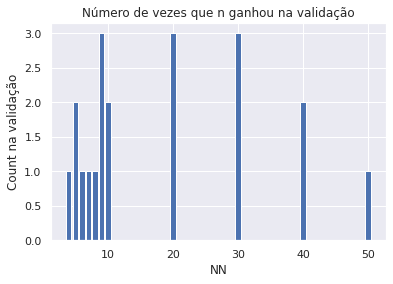

In [87]:
unique, counts = np.unique(melhores, return_counts=True)
plt.bar(unique, counts)
plt.title('Número de vezes que n ganhou na validação')
plt.xlabel('NN')
plt.ylabel('Count na validação')

In [88]:
knn_model = KNeighborsClassifier(n_neighbors=int(np.median(melhores)))
knn_model.fit(X_new_train, y_train)

print(classification_report(y_test, knn_model.predict(X_new_test)))
print(accuracy_score(y_test, knn_model.predict(X_new_test)))

              precision    recall  f1-score   support

      Action       0.37      0.43      0.40       157
   Adventure       0.28      0.24      0.26       111
Free to Play       0.50      0.20      0.29         5
       Indie       0.49      0.58      0.53       151
    Strategy       0.29      0.19      0.23       107

    accuracy                           0.38       531
   macro avg       0.39      0.33      0.34       531
weighted avg       0.37      0.38      0.37       531

0.384180790960452


In [89]:
N = 5000

def bootstrap_acc(df, n):
    size = len(df)
    values = np.zeros(n)
    for i in range(n):
        sample = df.sample(size, replace=True)
        values[i] = accuracy_score(sample.iloc[:,-1], knn_model.predict(sample.iloc[:,:5]))
    return values

bm_values = bootstrap_acc(bt_df, N)

def percentile(bm_values, init, final):
    inferior = np.percentile(bm_values, init)
    superior = np.percentile(bm_values, final)
    return [inferior, superior]

result1 = percentile(bm_values, 2.5, 97.5)
print(result1)

[0.3427024482109228, 0.4256120527306968]


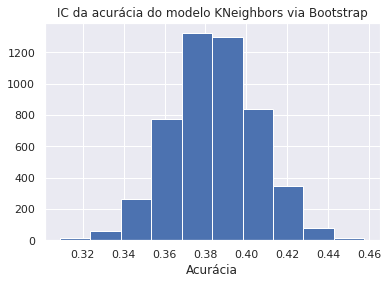

In [90]:
plt.hist(bm_values)
plt.title("IC da acurácia do modelo KNeighbors via Bootstrap")
plt.xlabel("Acurácia")
plt.show()